In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, f1_score, precision_score, recall_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingClassifier

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV


import joblib

from sklearn.ensemble import VotingClassifier, StackingClassifier


In [3]:
def generate_ibm_hr_dataset(n_samples=1_000_000, seed=42):
    """
    Gera um dataset sintético inspirado no IBM HR Analytics com relações mais realistas
 
    Parameters:
    n_samples (int): Número de amostras a gerar
    seed (int): Seed para reprodutibilidade
 
    Returns:
    pd.DataFrame: Dataset gerado
    """
    np.random.seed(seed)
 
    # Gerando dados base
    data = {}
 
    # Idade com distribuição mais realista (concentrada entre 25-50 anos)
    data['Age'] = np.random.normal(38, 10, n_samples).astype(int)
    data['Age'] = np.clip(data['Age'], 18, 65)
 
    # Gênero
    data['Gender'] = np.random.choice(['Female', 'Male'], n_samples, p=[0.4, 0.6])
 
    # Educação (1-5: Below College, College, Bachelor, Master, Doctor)
    education_probs = [0.05, 0.15, 0.40, 0.30, 0.10]
    data['Education'] = np.random.choice([1, 2, 3, 4, 5], n_samples, p=education_probs)
 
    # Campo educacional baseado no nível de educação
    education_fields = ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
    data['EducationField'] = np.random.choice(education_fields, n_samples)
 
    # Departamento
    dept_probs = [0.45, 0.40, 0.15]  # Sales mais comum, HR menos comum
    data['Department'] = np.random.choice(['Sales', 'Research & Development', 'Human Resources'],
                                        n_samples, p=dept_probs)
 
    # Job Role baseado no departamento
    job_roles = {
        'Sales': ['Sales Executive', 'Sales Representative', 'Manager'],
        'Research & Development': ['Research Scientist', 'Laboratory Technician', 'Research Director', 'Manager'],
        'Human Resources': ['Human Resources', 'Manager']
    }
 
    data['JobRole'] = np.empty(n_samples, dtype=object)
    for dept in job_roles:
        mask = np.array(data['Department']) == dept
        n_dept = mask.sum()
        if n_dept > 0:
            data['JobRole'][mask] = np.random.choice(job_roles[dept], n_dept)
 
    # Job Level correlacionado com idade e educação
    base_level = np.ones(n_samples)
    age_bonus = (np.array(data['Age']) - 18) / 47 * 2  # 0-2 pontos baseado na idade
    edu_bonus = (np.array(data['Education']) - 1) / 4 * 2  # 0-2 pontos baseado na educação
 
    data['JobLevel'] = np.round(base_level + age_bonus + edu_bonus).astype(int)
    data['JobLevel'] = np.clip(data['JobLevel'], 1, 5)
 
    # Total Working Years correlacionado com idade
    data['TotalWorkingYears'] = np.maximum(0, data['Age'] - 18 - np.random.randint(0, 5, n_samples))
 
    # Years at Company (não pode ser maior que TotalWorkingYears)
    data['YearsAtCompany'] = np.random.randint(0, 21, n_samples)
    data['YearsAtCompany'] = np.minimum(data['YearsAtCompany'], data['TotalWorkingYears'])
 
    # Years in Current Role (não pode ser maior que YearsAtCompany)
    data['YearsInCurrentRole'] = np.random.randint(0, 11, n_samples)
    data['YearsInCurrentRole'] = np.minimum(data['YearsInCurrentRole'], data['YearsAtCompany'])
 
    # Years Since Last Promotion
    data['YearsSinceLastPromotion'] = np.random.randint(0, 8, n_samples)
    data['YearsSinceLastPromotion'] = np.minimum(data['YearsSinceLastPromotion'], data['YearsAtCompany'])
 
    # Years With Current Manager
    data['YearsWithCurrManager'] = np.random.randint(0, 8, n_samples)
    data['YearsWithCurrManager'] = np.minimum(data['YearsWithCurrManager'], data['YearsInCurrentRole'])
 
    # Número de empresas trabalhadas (correlacionado com anos totais de trabalho)
    max_companies = np.minimum(data['TotalWorkingYears'] // 2, 9)
    data['NumCompaniesWorked'] = np.array([np.random.randint(0, max(1, mc) + 1) for mc in max_companies])
 
    # Monthly Income correlacionado com JobLevel, Education e TotalWorkingYears
    base_income = 2000
    level_factor = data['JobLevel'] * 2000
    education_factor = data['Education'] * 500
    experience_factor = data['TotalWorkingYears'] * 100
    noise = np.random.normal(0, 1000, n_samples)
 
    data['MonthlyIncome'] = base_income + level_factor + education_factor + experience_factor + noise
    data['MonthlyIncome'] = np.clip(data['MonthlyIncome'].astype(int), 1000, 20000)
 
    # Rates
    data['DailyRate'] = np.random.randint(100, 1500, n_samples)
    data['HourlyRate'] = np.random.randint(30, 100, n_samples)
    data['MonthlyRate'] = np.random.randint(2000, 27000, n_samples)
 
    # Distance from home (distribuição exponencial - mais pessoas moram perto)
    data['DistanceFromHome'] = np.random.exponential(7, n_samples).astype(int) + 1
    data['DistanceFromHome'] = np.clip(data['DistanceFromHome'], 1, 29)
 
    # Business Travel
    travel_probs = [0.70, 0.20, 0.10]  # Maioria viaja raramente
    data['BusinessTravel'] = np.random.choice(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'],
                                            n_samples, p=travel_probs)
 
    # Satisfação e envolvimento
    data['EnvironmentSatisfaction'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.20, 0.40, 0.30])
    data['JobSatisfaction'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.20, 0.40, 0.30])
    data['RelationshipSatisfaction'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.20, 0.40, 0.30])
    data['JobInvolvement'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.05, 0.15, 0.50, 0.30])
    data['WorkLifeBalance'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.10, 0.25, 0.45, 0.20])
 
    # Performance Rating (maioria boa performance)
    data['PerformanceRating'] = np.random.choice([3, 4], n_samples, p=[0.84, 0.16])
 
    # Percent Salary Hike correlacionado com Performance Rating
    data['PercentSalaryHike'] = np.where(
        data['PerformanceRating'] == 4,
        np.random.randint(15, 26, n_samples),
        np.random.randint(11, 18, n_samples)
    )
 
    # Stock Option Level correlacionado com JobLevel
    data['StockOptionLevel'] = np.random.choice([0, 1, 2, 3], n_samples,
                                               p=[0.40, 0.35, 0.20, 0.05])
    high_level_mask = data['JobLevel'] >= 4
    data['StockOptionLevel'][high_level_mask] = np.random.choice([1, 2, 3],
                                                                 high_level_mask.sum(),
                                                                 p=[0.30, 0.50, 0.20])
 
    # Training Times Last Year
    data['TrainingTimesLastYear'] = np.random.choice([0, 1, 2, 3, 4, 5, 6], n_samples,
                                                    p=[0.05, 0.10, 0.25, 0.30, 0.20, 0.08, 0.02])
 
    # Marital Status
    data['MaritalStatus'] = np.random.choice(['Single', 'Married', 'Divorced'], n_samples,
                                           p=[0.32, 0.55, 0.13])
 
    # OverTime - maior probabilidade para níveis menores e pessoas mais jovens
    overtime_base_prob = 0.28
    age_factor = (65 - data['Age']) / 47 * 0.1  # Jovens trabalham mais overtime
    level_factor = (5 - data['JobLevel']) / 4 * 0.1  # Níveis menores trabalham mais overtime
 
    overtime_prob = np.clip(overtime_base_prob + age_factor + level_factor, 0.1, 0.5)
    data['OverTime'] = [np.random.choice(['Yes', 'No'], p=[p, 1-p]) for p in overtime_prob]
 
    # Attrition - baseado em múltiplos fatores
    attrition_score = np.zeros(n_samples)
 
    # Fatores que aumentam attrition
    attrition_score += (data['JobSatisfaction'] == 1) * 0.15
    attrition_score += (data['EnvironmentSatisfaction'] == 1) * 0.10
    attrition_score += (data['WorkLifeBalance'] == 1) * 0.10
    attrition_score += (np.array(data['OverTime']) == 'Yes') * 0.08
    attrition_score += (data['YearsSinceLastPromotion'] > 5) * 0.05
    attrition_score += (data['DistanceFromHome'] > 20) * 0.05
    attrition_score += (np.array(data['MaritalStatus']) == 'Single') * 0.03
    attrition_score += (data['NumCompaniesWorked'] > 5) * 0.04
 
    # Fatores que diminuem attrition
    attrition_score -= (data['JobLevel'] >= 4) * 0.10
    attrition_score -= (data['YearsAtCompany'] > 10) * 0.08
    attrition_score -= (data['StockOptionLevel'] > 0) * 0.05
 
    # Probabilidade base de 16%
    attrition_prob = np.clip(0.16 + attrition_score, 0.05, 0.50)
    data['Attrition'] = [np.random.choice(['Yes', 'No'], p=[p, 1-p]) for p in attrition_prob]
 
    # Campos fixos
    data['EmployeeCount'] = np.ones(n_samples, dtype=int)
    data['EmployeeNumber'] = np.arange(1, n_samples + 1)
    data['Over18'] = ['Y'] * n_samples
    data['StandardHours'] = [80] * n_samples
 
    # Criar DataFrame
    df = pd.DataFrame(data)
 
    # Reordenar colunas para match com o dataset original
    column_order = [
        'Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
        'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
        'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
        'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'
    ]
 
    return df[column_order]

In [4]:
df = generate_ibm_hr_dataset(n_samples=1_000_000, seed=42)


In [5]:
###Realiza o Tratamento das colunas

# Remover colunas com valores únicos
single_value_cols = ['EmployeeCount', 'Over18', 'StandardHours']
df = df.drop(columns=single_value_cols)
print(f"Colunas removidas (valor único): {single_value_cols}")

# Remover EmployeeNumber (ID único)
df = df.drop(columns=['EmployeeNumber'])

Colunas removidas (valor único): ['EmployeeCount', 'Over18', 'StandardHours']


In [6]:
###Cria uma váriavel com os dados do dataframe original
original_df = df.copy()

# 1. Análise Exploratória

###  1.1 Análise estatística completa das variáveis

In [7]:
#Função que calcula medidas estatísticas importantes como média, mediana, desvio padrão, mínimo, máximo, frequência de valores e contagem de registros únicos.
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000000.0,NaN,NaN,NaN,37.573109,9.752131,18.0,31.0,37.0,44.0,65.0
Attrition,1000000,2,No,821159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,1000000,3,Travel_Rarely,699436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DailyRate,1000000.0,NaN,NaN,NaN,800.110722,404.135932,100.0,451.0,800.0,1150.0,1499.0
Department,1000000,3,Sales,450470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,1000000.0,NaN,NaN,NaN,7.389395,6.48702,1.0,3.0,5.0,10.0,29.0
Education,1000000.0,NaN,NaN,NaN,3.250821,0.993399,1.0,3.0,3.0,4.0,5.0
EducationField,1000000,6,Marketing,167012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EnvironmentSatisfaction,1000000.0,NaN,NaN,NaN,2.898258,0.944161,1.0,2.0,3.0,4.0,4.0
Gender,1000000,2,Male,599364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Verifica se possui valores ausentes nas linhas do DataFrame
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [9]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,42,No,Travel_Rarely,575,Research & Development,1,3,Marketing,4,Female,...,4,2,1,24,3,4,5,0,3,0
1,36,No,Travel_Rarely,535,Human Resources,2,4,Human Resources,4,Male,...,3,4,1,18,5,2,17,8,7,3
2,44,No,Travel_Rarely,286,Research & Development,2,4,Medical,3,Male,...,3,1,2,22,3,3,20,0,1,0
3,53,Yes,Travel_Frequently,746,Sales,11,2,Medical,4,Male,...,3,4,0,31,1,3,3,3,0,3
4,35,No,Travel_Rarely,408,Research & Development,7,5,Technical Degree,2,Male,...,3,2,1,17,2,1,14,5,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,42,No,Travel_Rarely,262,Research & Development,10,4,Life Sciences,3,Male,...,3,4,1,20,3,4,6,4,6,4
999996,39,Yes,Travel_Rarely,340,Sales,20,3,Life Sciences,1,Male,...,3,4,1,18,6,3,14,10,2,3
999997,36,No,Travel_Frequently,777,Sales,15,4,Marketing,2,Female,...,3,4,2,16,4,4,9,2,6,1
999998,52,Yes,Travel_Rarely,1148,Human Resources,2,3,Human Resources,4,Female,...,3,2,1,31,4,1,18,0,4,0


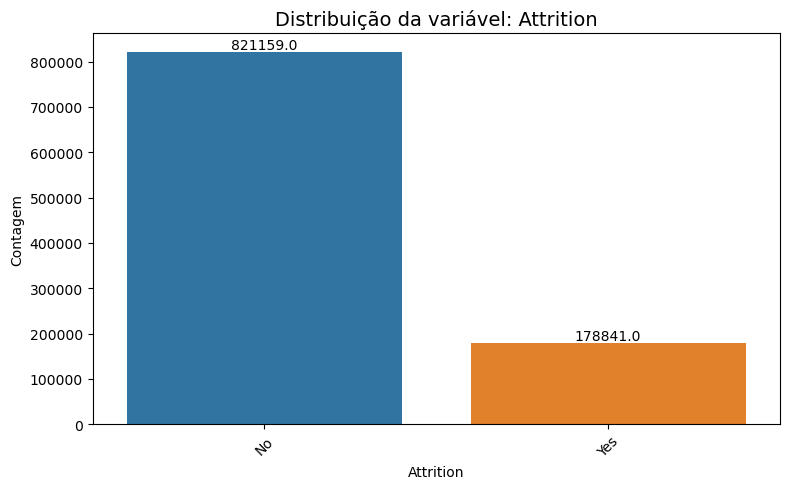

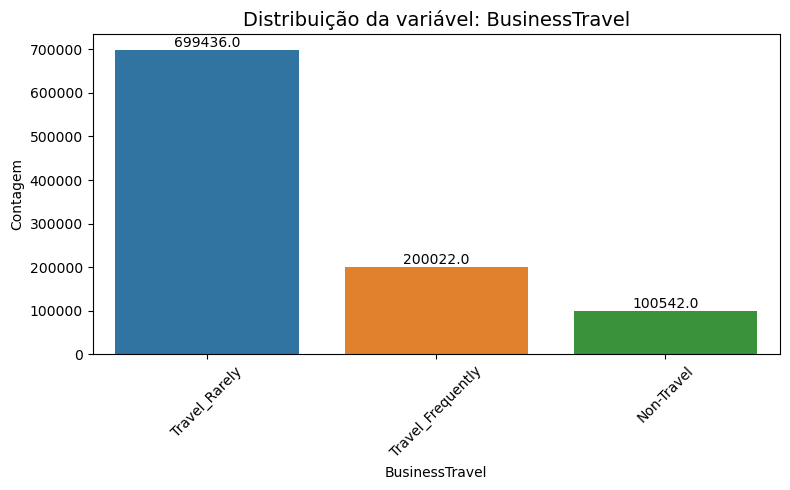

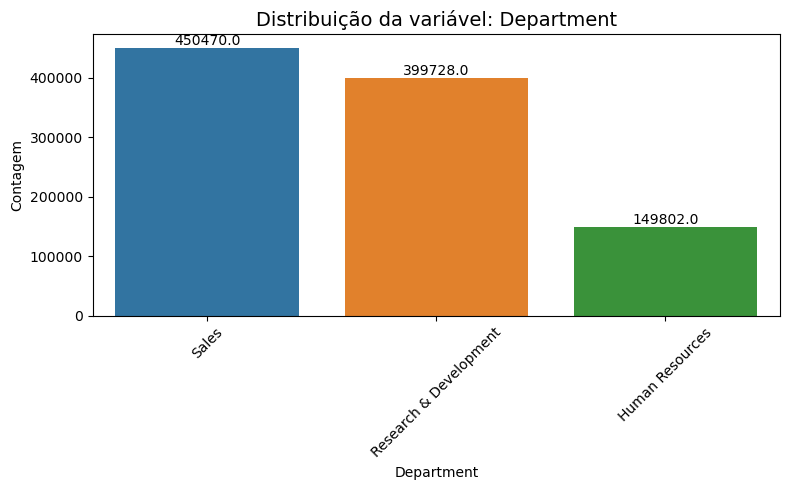

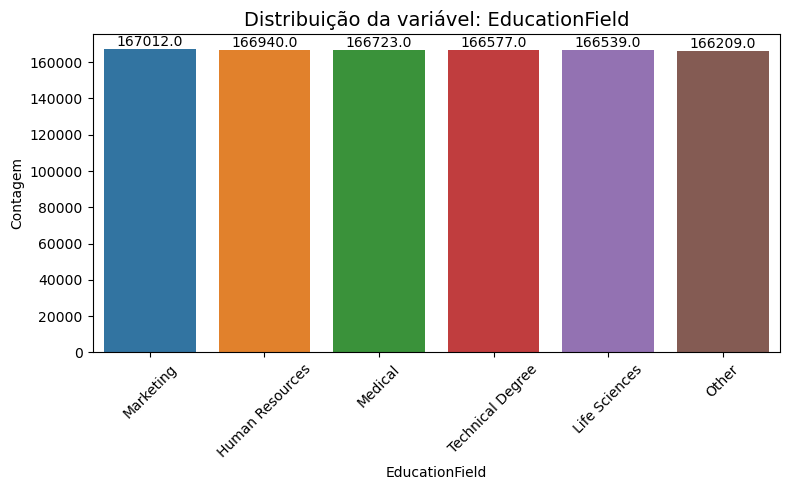

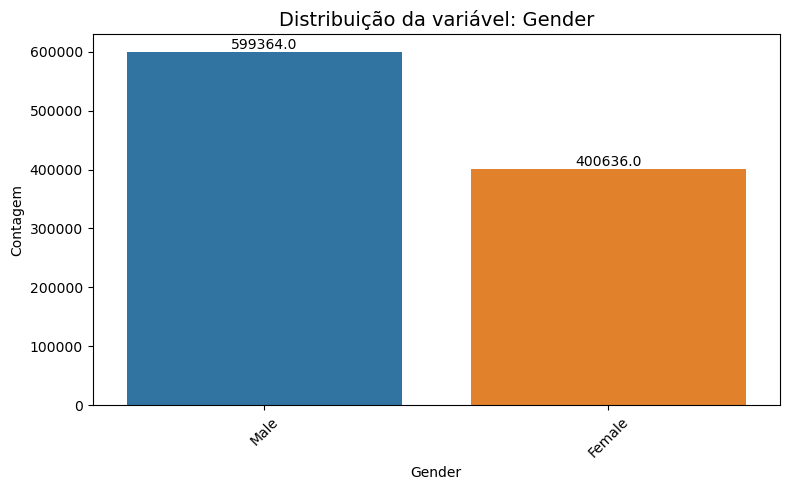

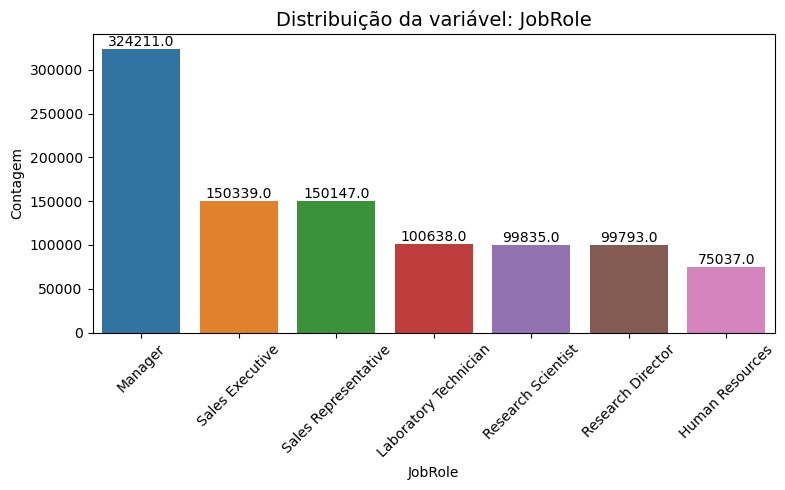

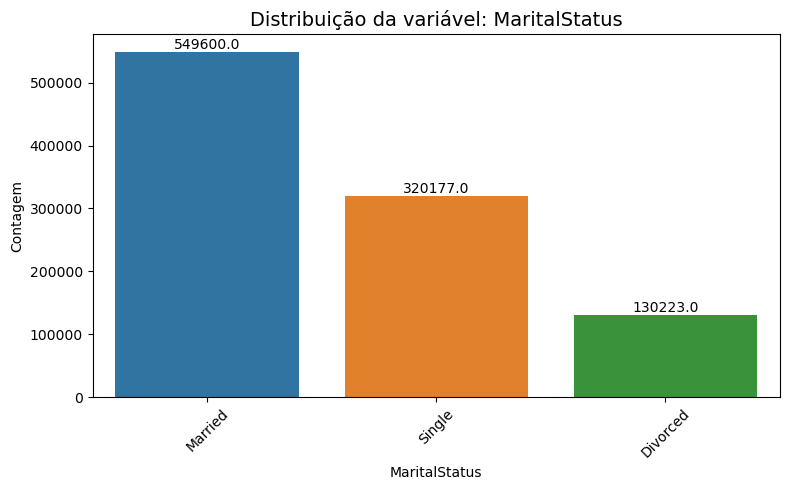

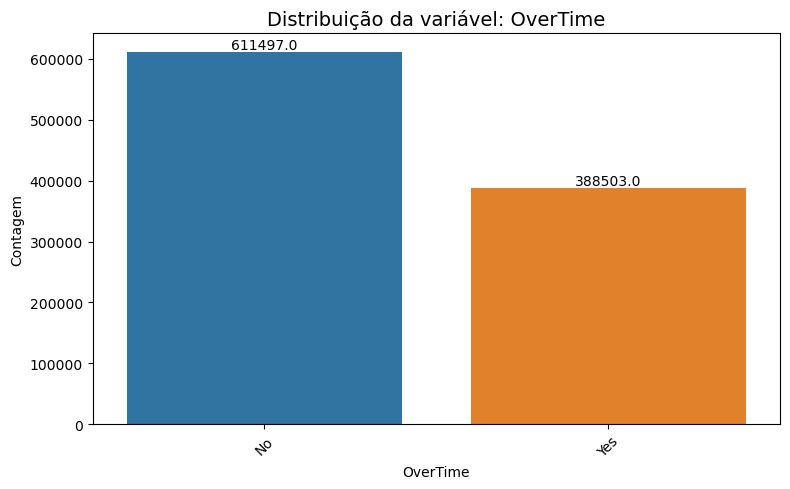

In [10]:
#Determina todas as colunas que são variaveis númericas
cat_cols = df.select_dtypes(include=['object', 'category']).columns

#Gera visões das variaveis categóricas em quantidade
for col in cat_cols:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribuição da variável: {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    
    # Adiciona rótulos de contagem acima das barras
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

#### Curva galciana pesquisar a relação se é possível aplicar ela ou outra método matematico

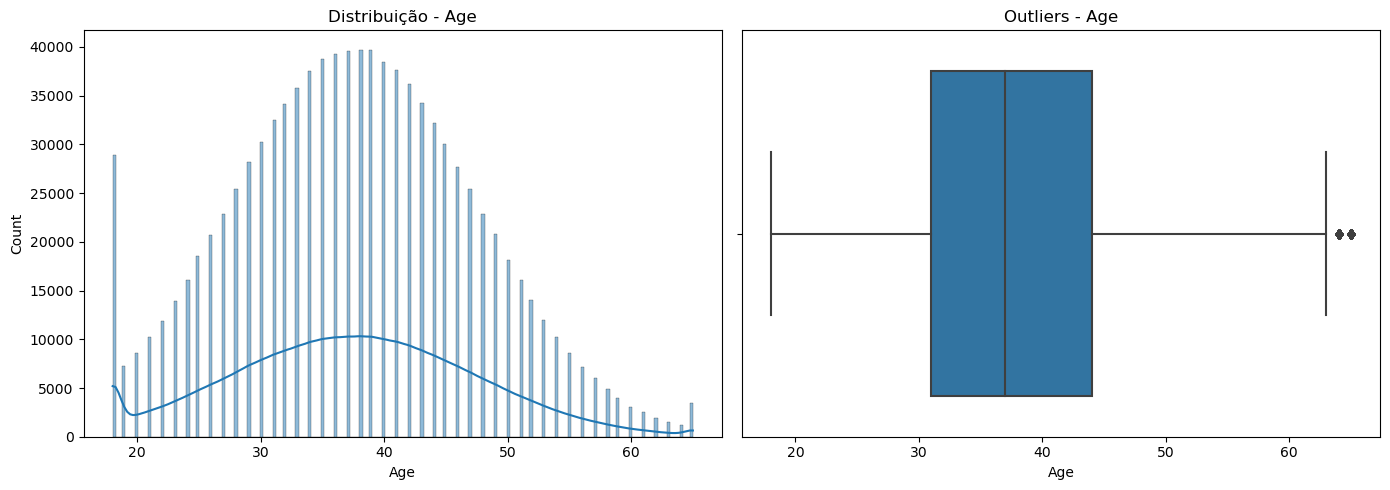

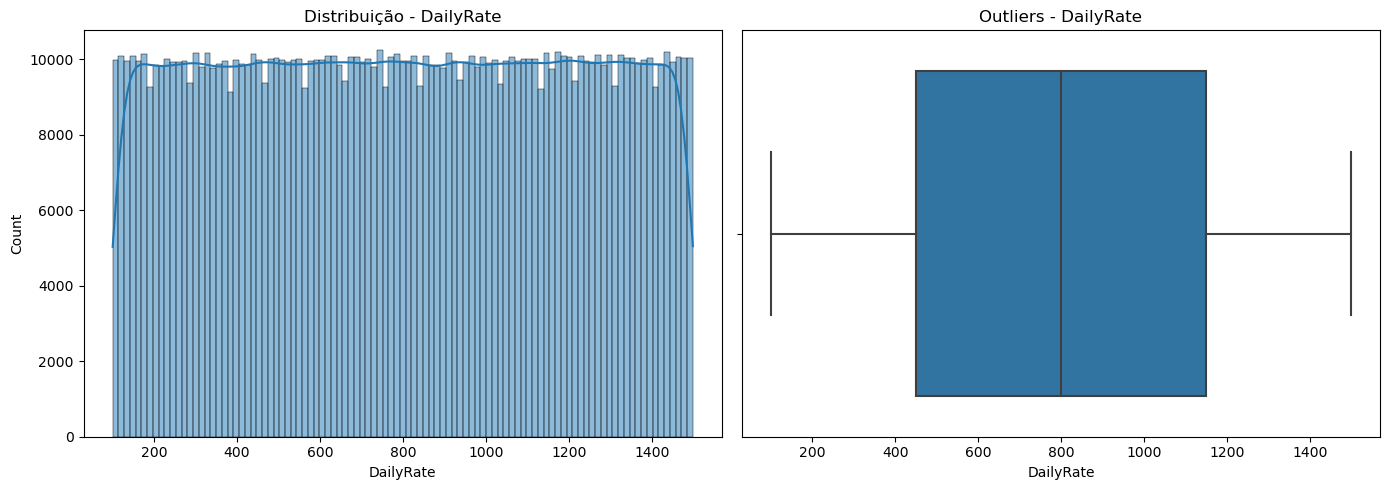

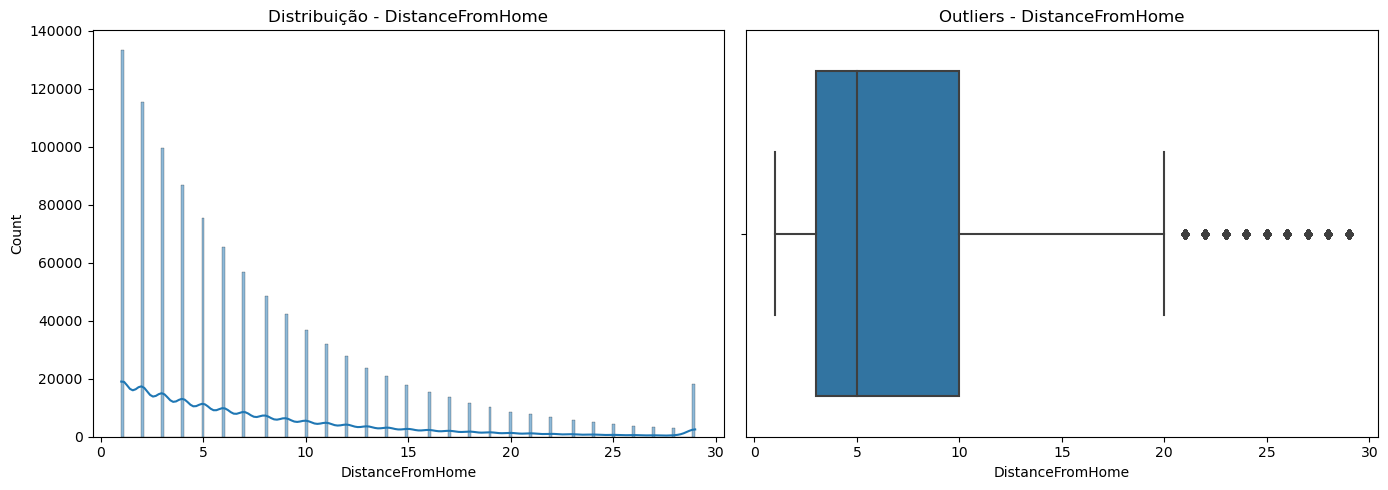

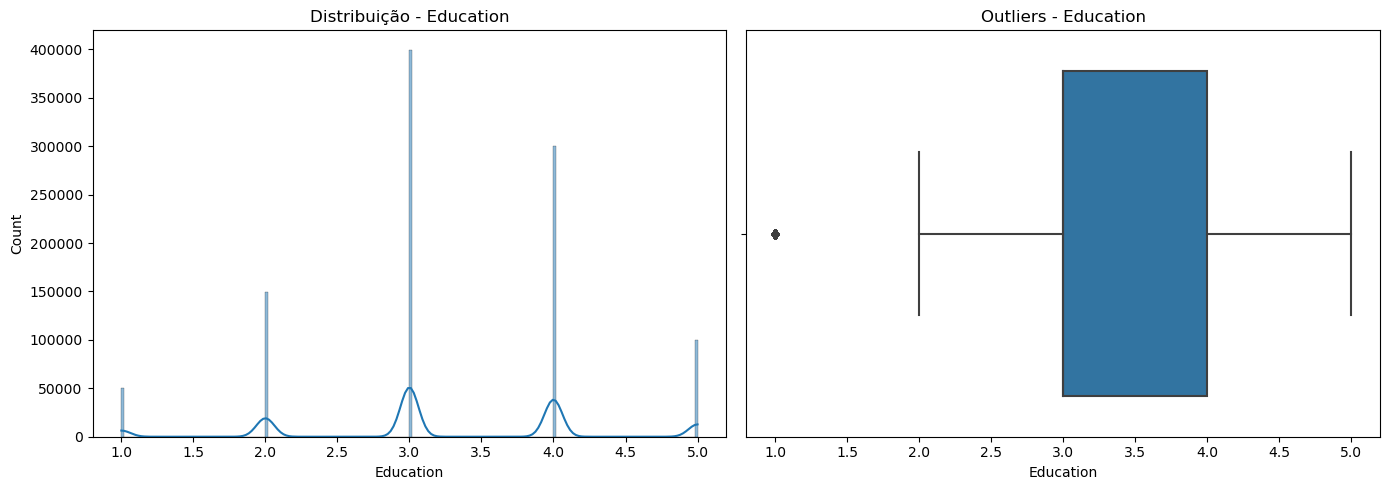

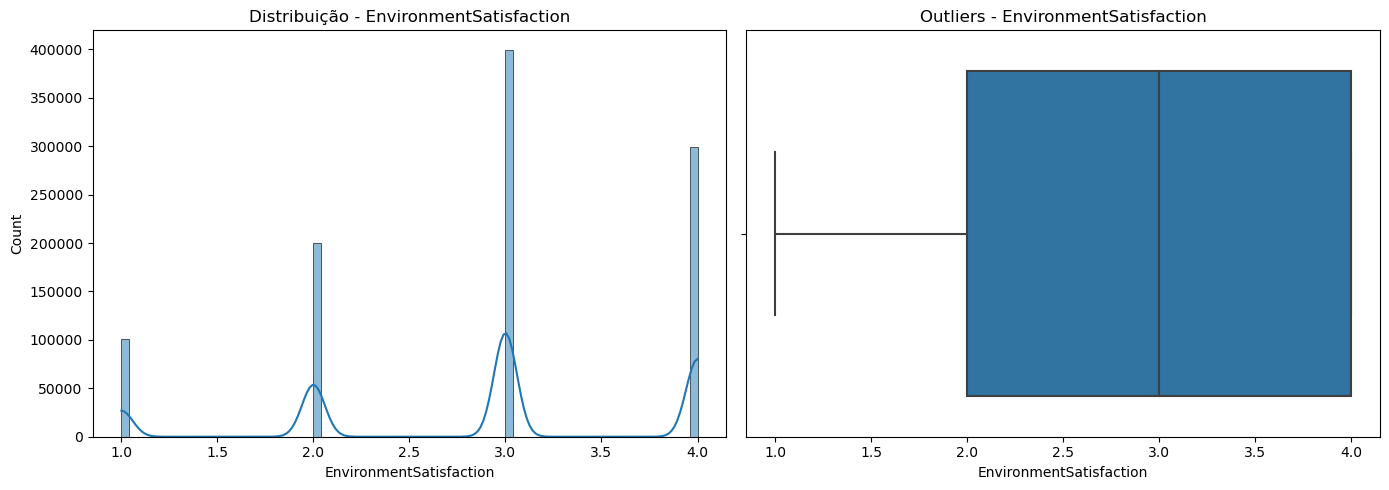

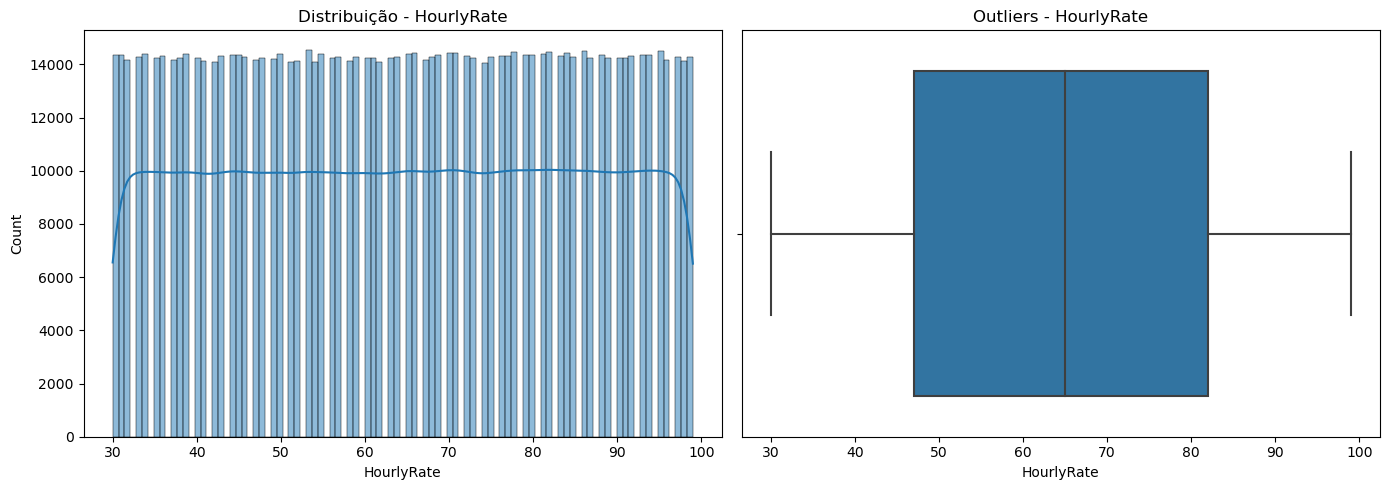

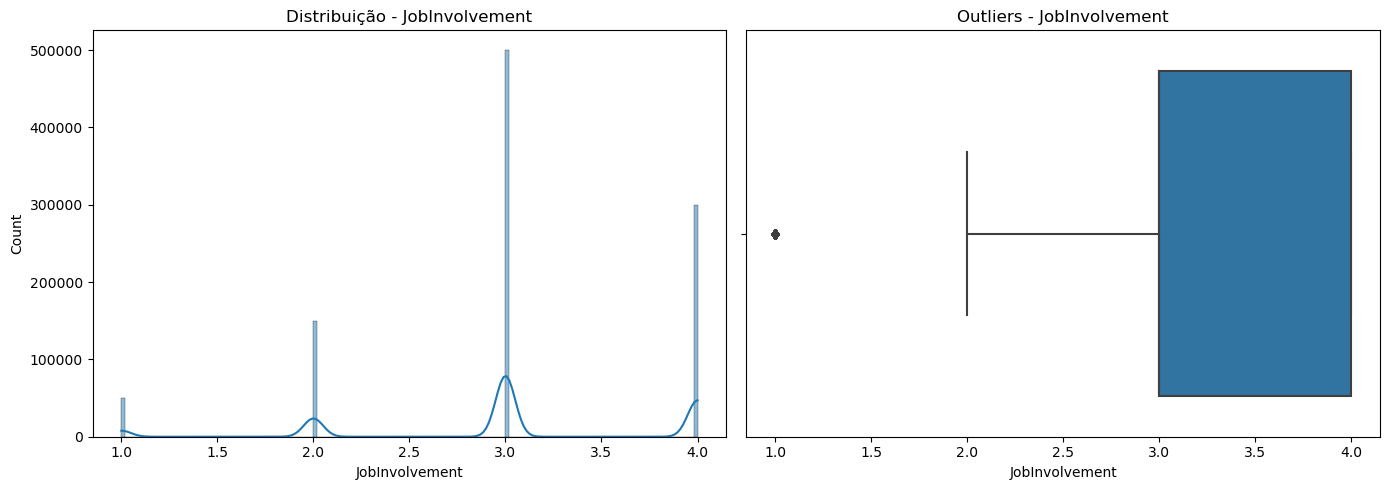

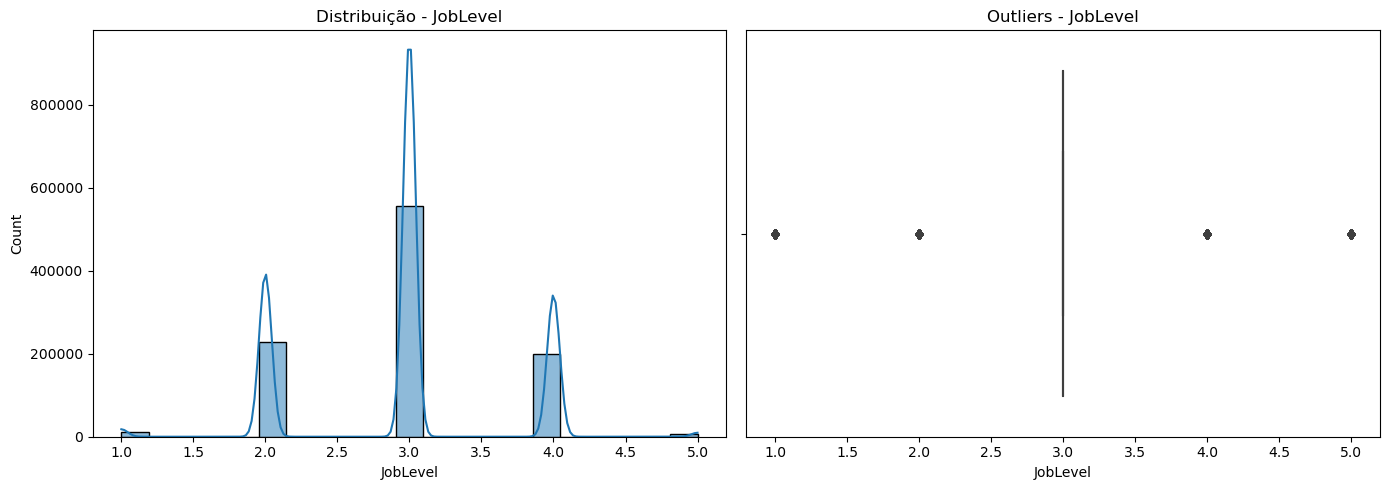

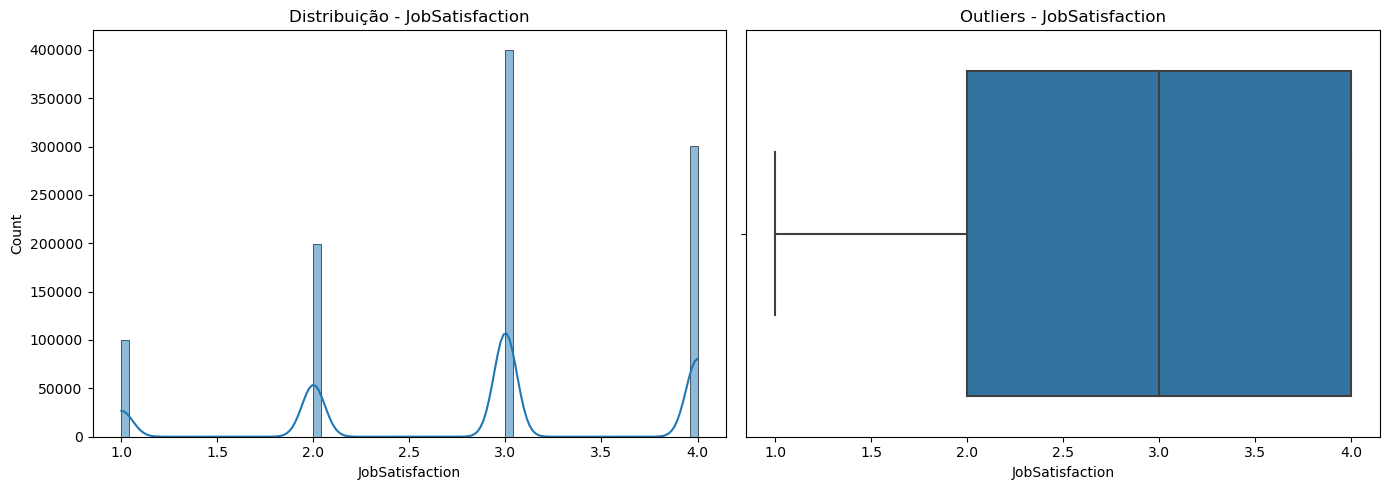

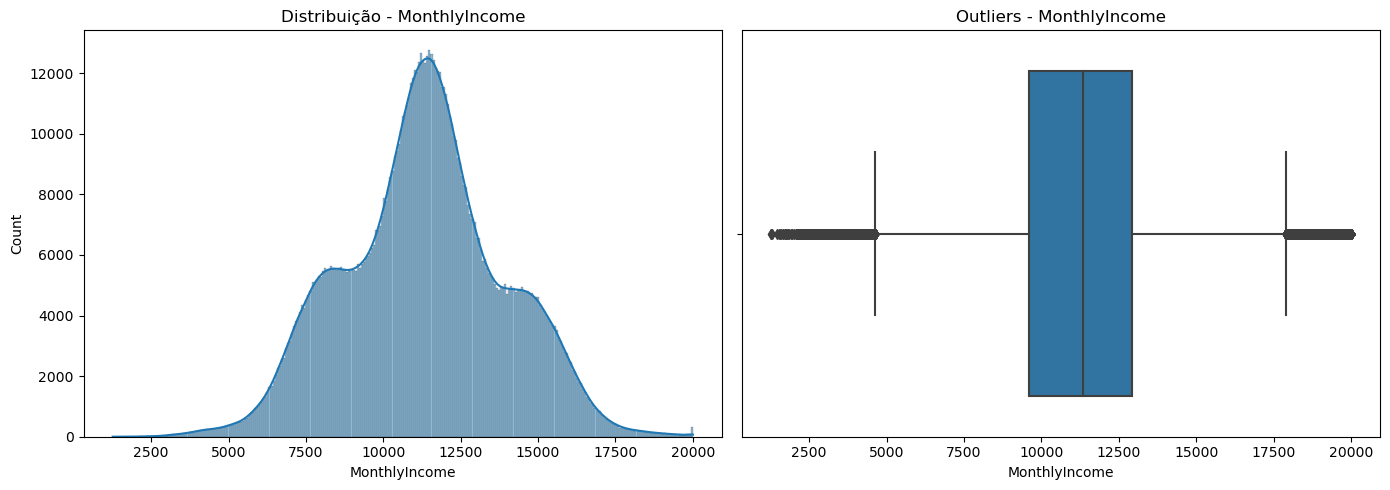

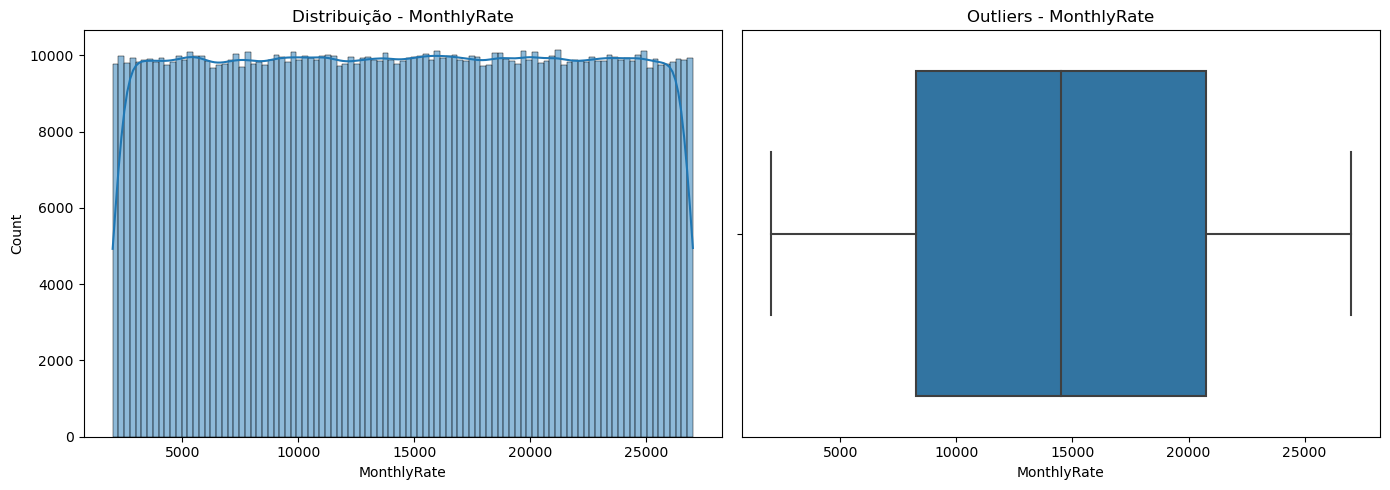

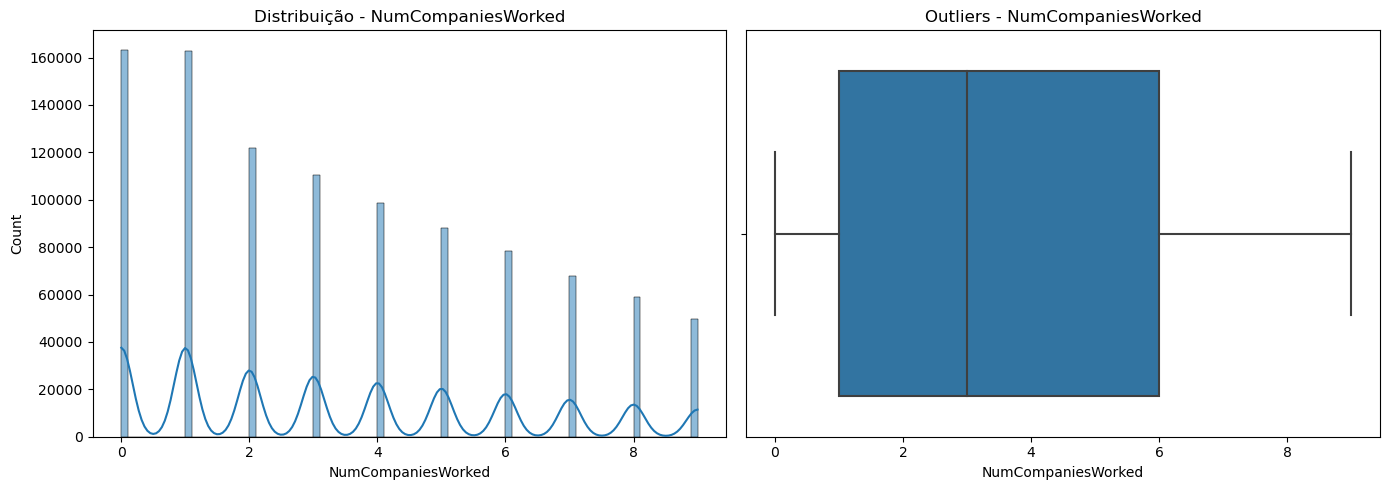

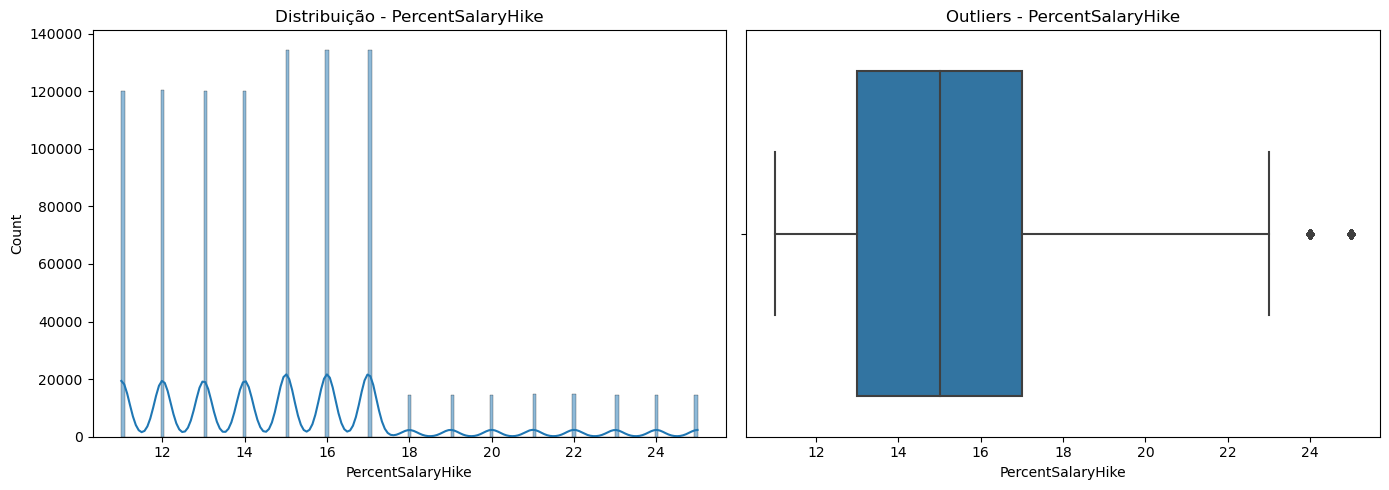

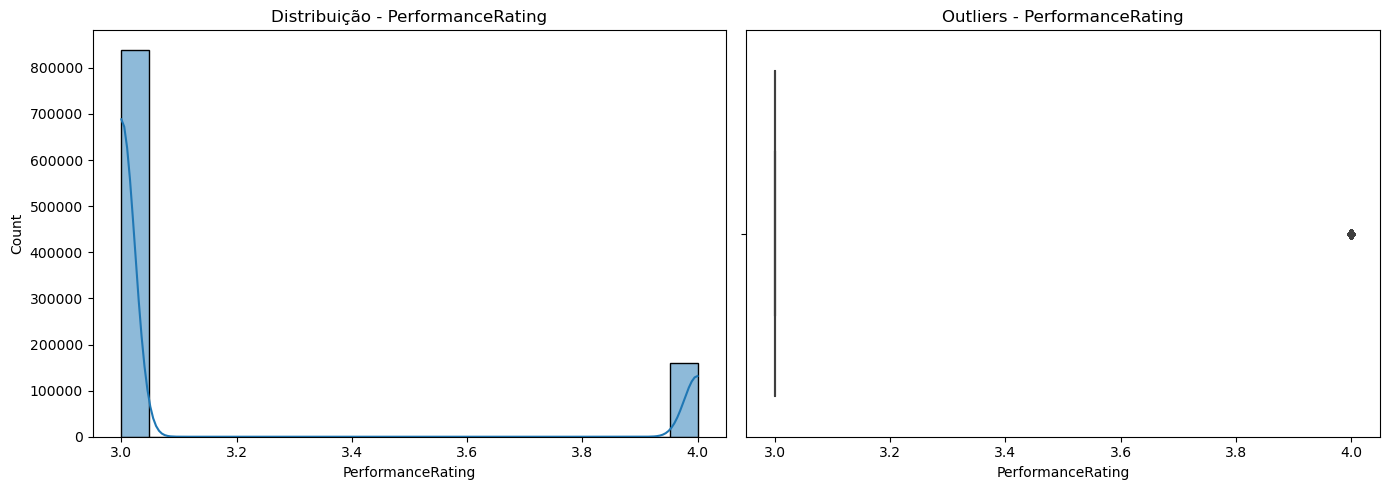

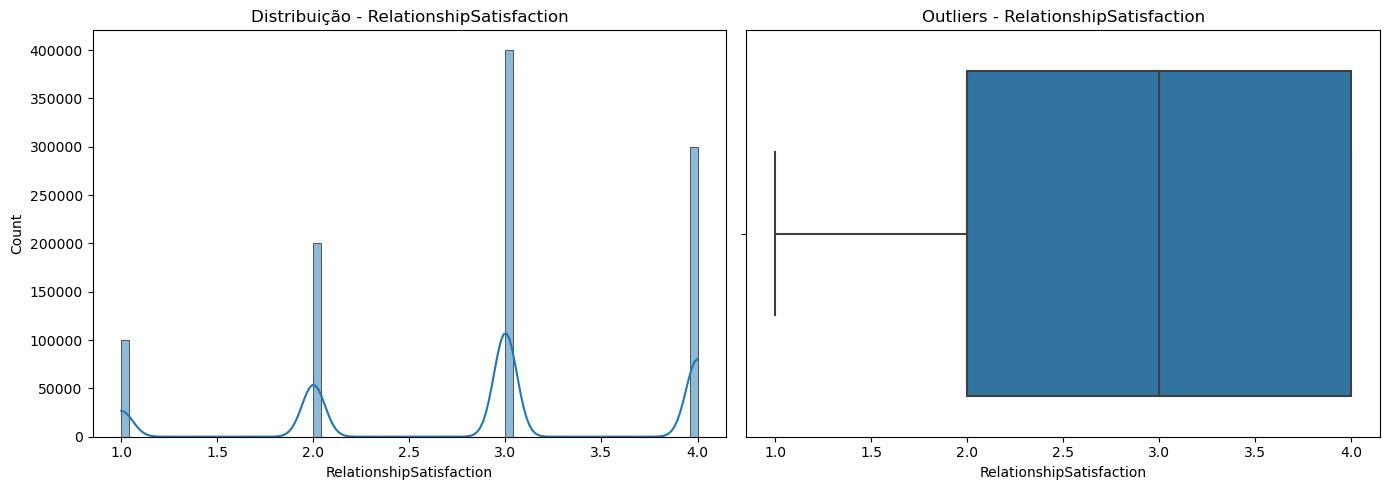

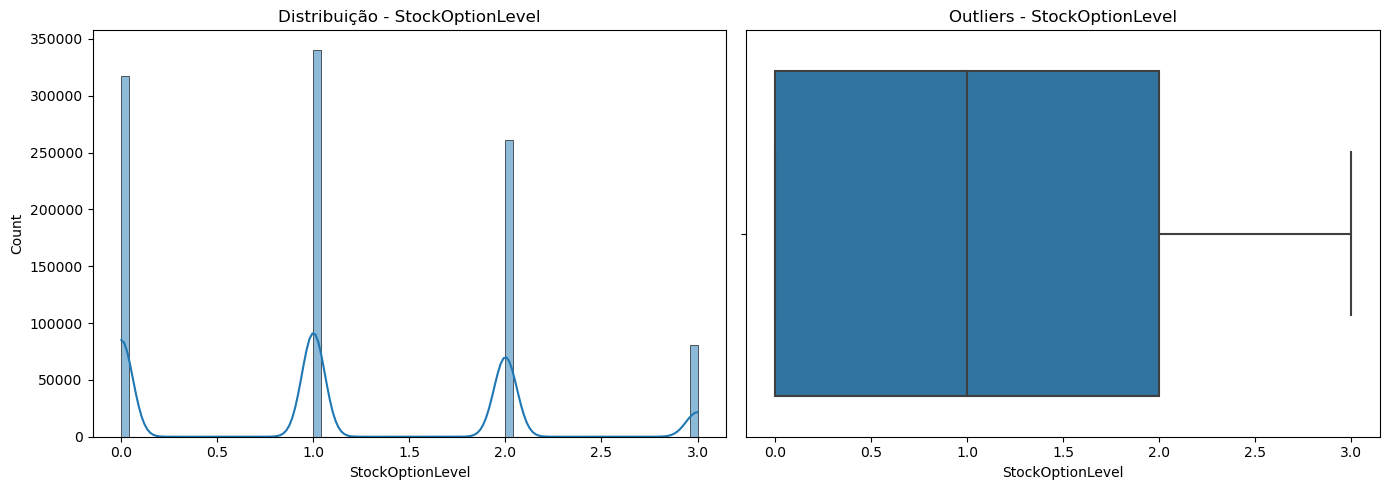

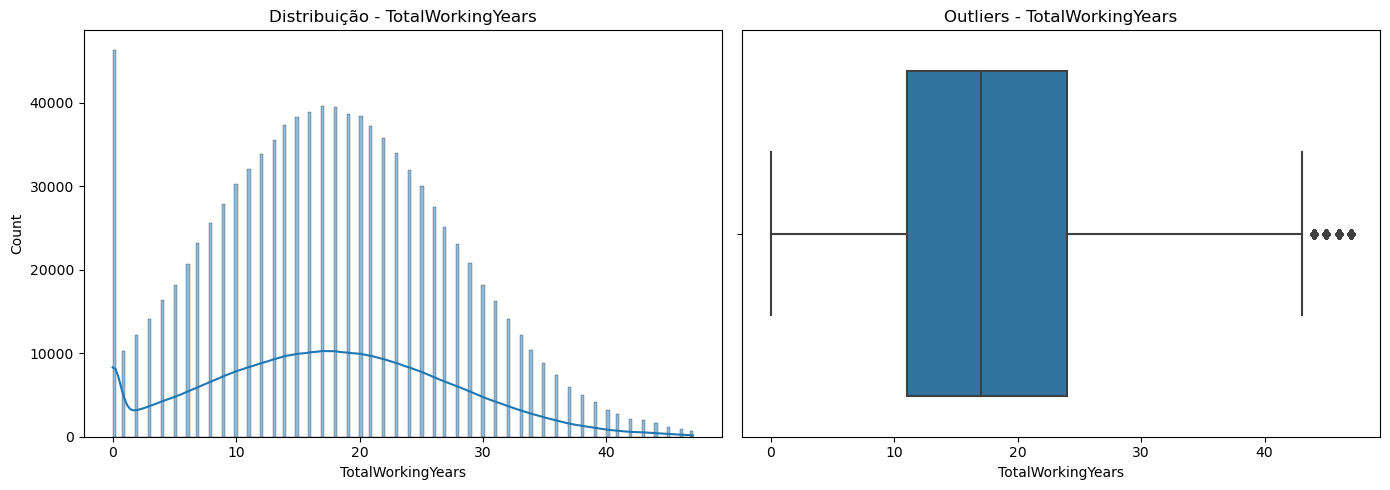

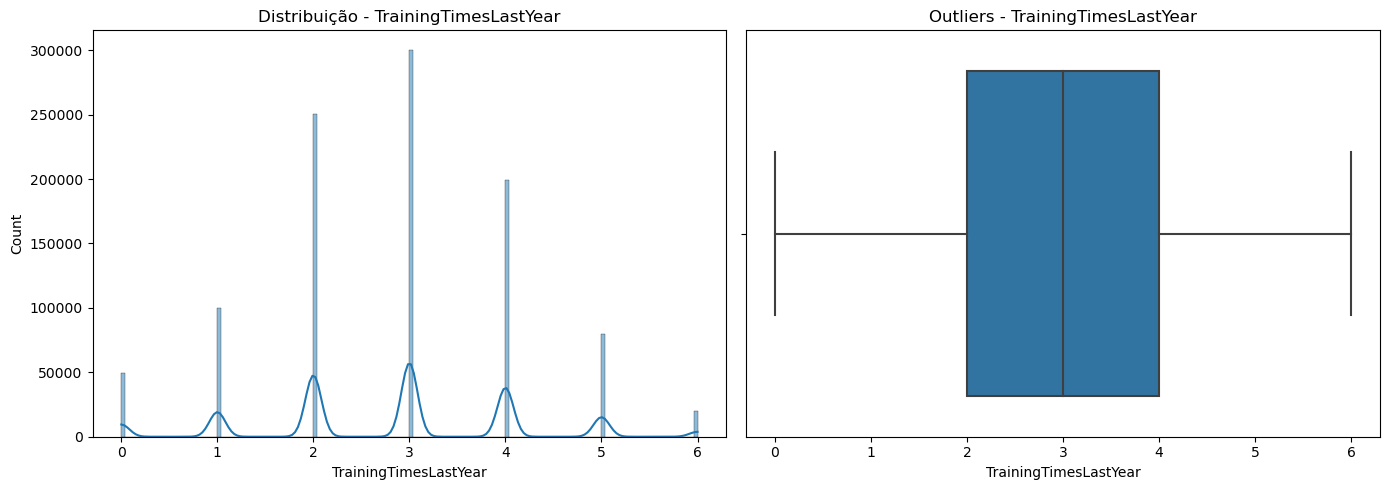

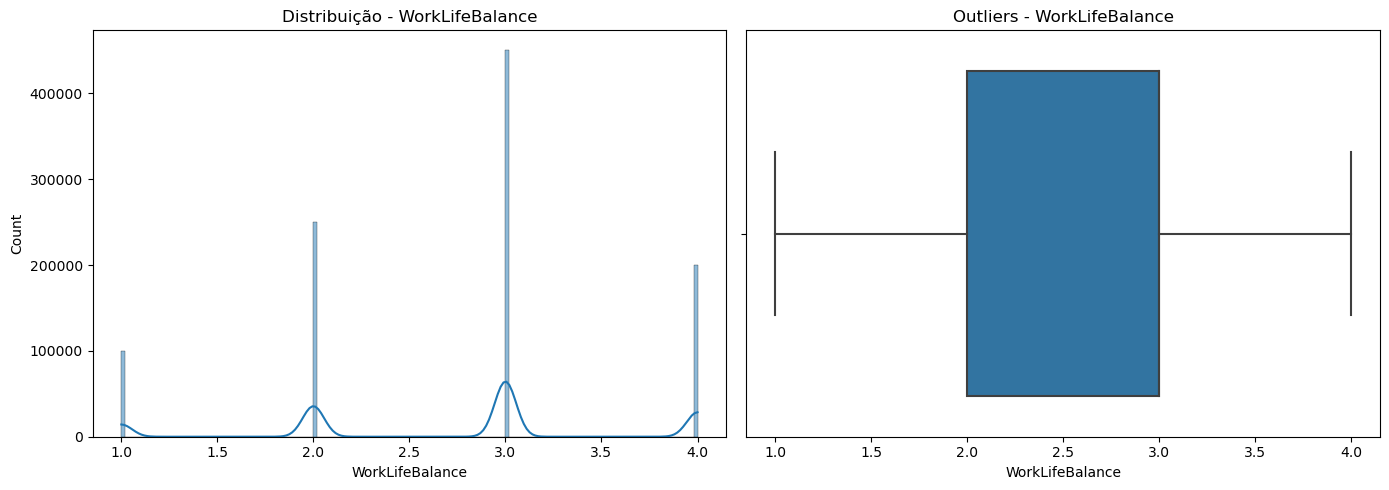

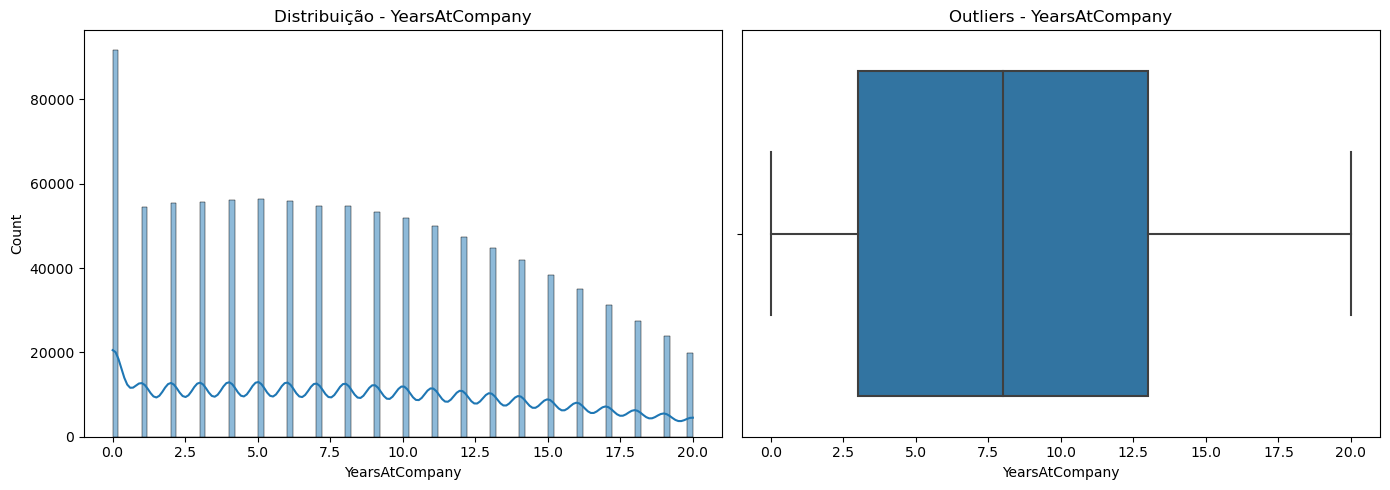

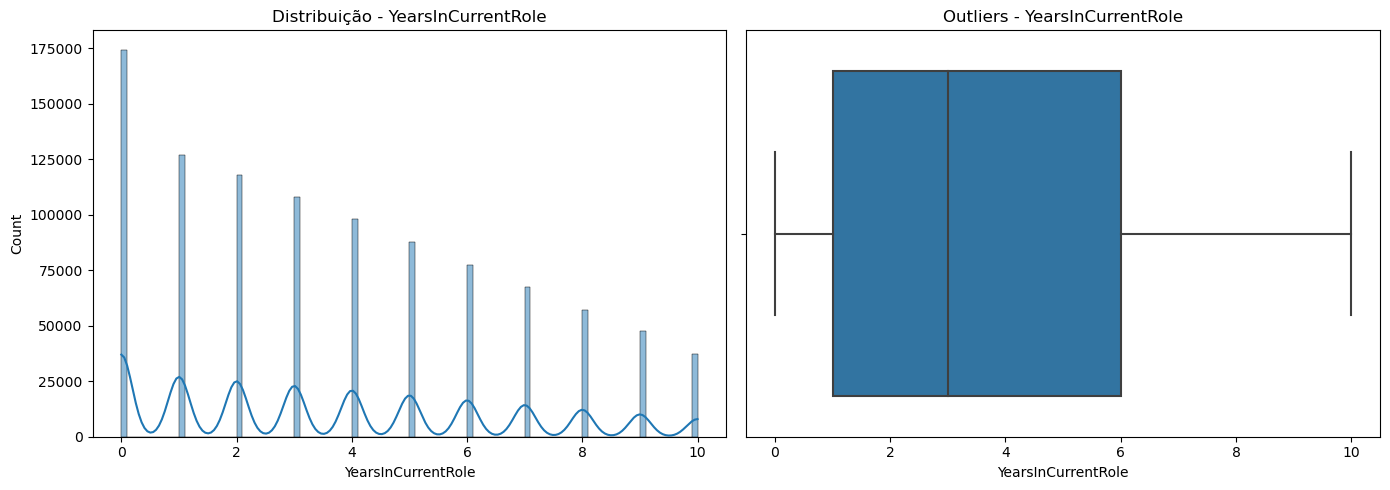

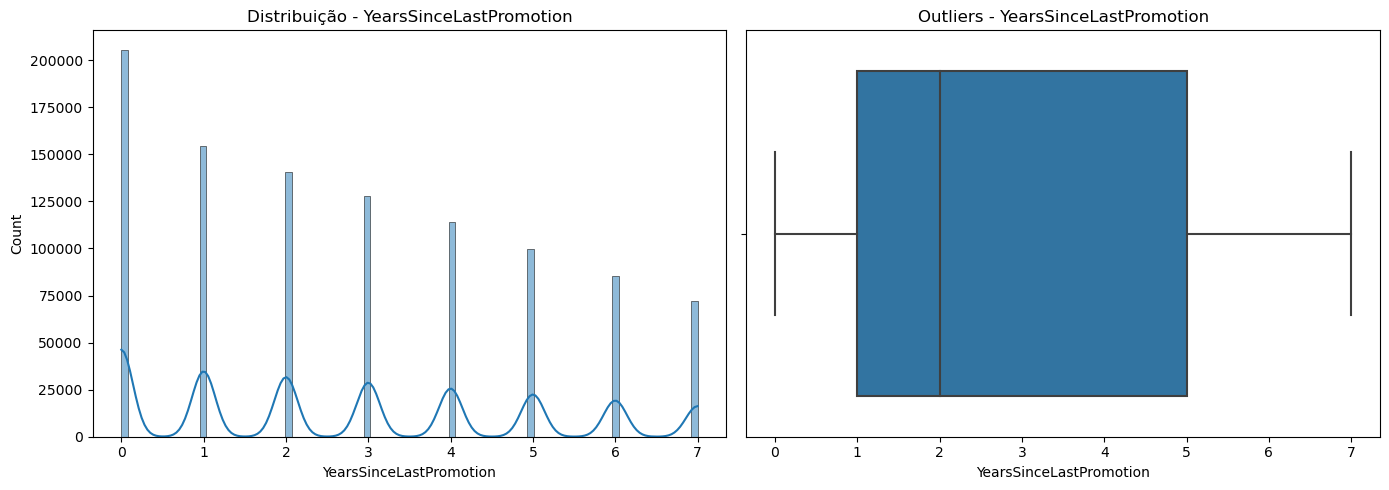

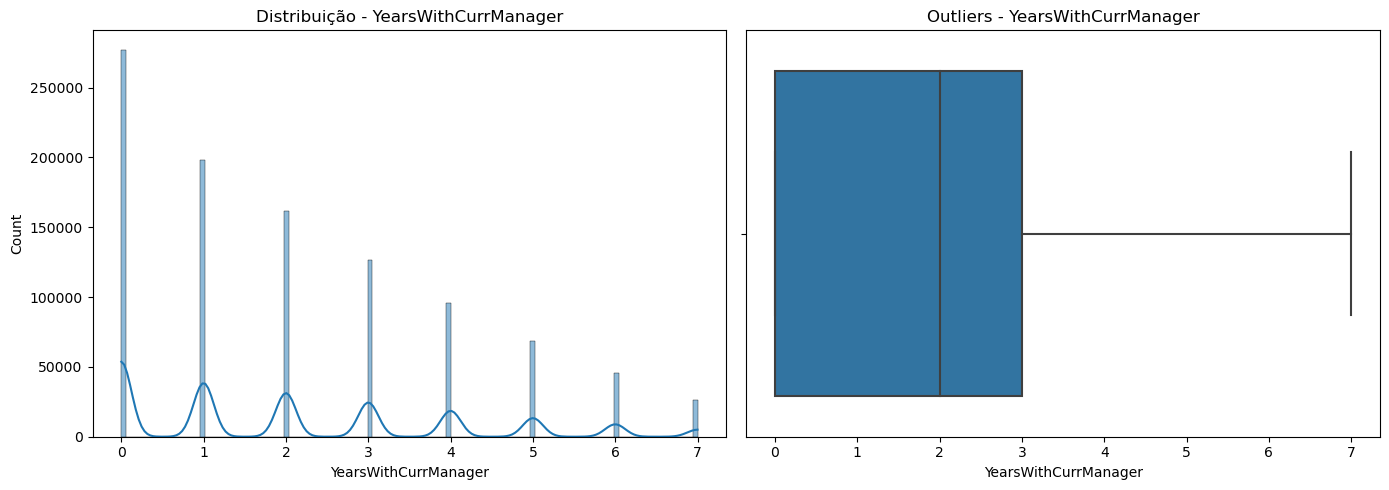

In [11]:
#Determina todas as colunas que são variaveis númericas
num_cols = df.select_dtypes(include=['int32', 'float32']).columns

#Gera visões das variaveis númericas em quantidade
for col in num_cols:
    plt.figure(figsize=(14, 5))

    # Histograma com KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição - {col}')

    # Boxplot para detectar outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Outliers - {col}')

    plt.tight_layout()
    plt.show()

### Correlação | Valor absoluto (|r|) | Força |  |
#### |------------------|------------------|------------------|----------------------------------|
#### | ±0.00 a ±0.30 | fraca ou nula | Fraca | Pode manter ambas |
#### | ±0.30 a ±0.70 | moderada | Moderada | Avaliar caso a caso |
#### | ±0.75 a ±1.00 | forte | Muito forte | Evitar usar juntas no modelo |

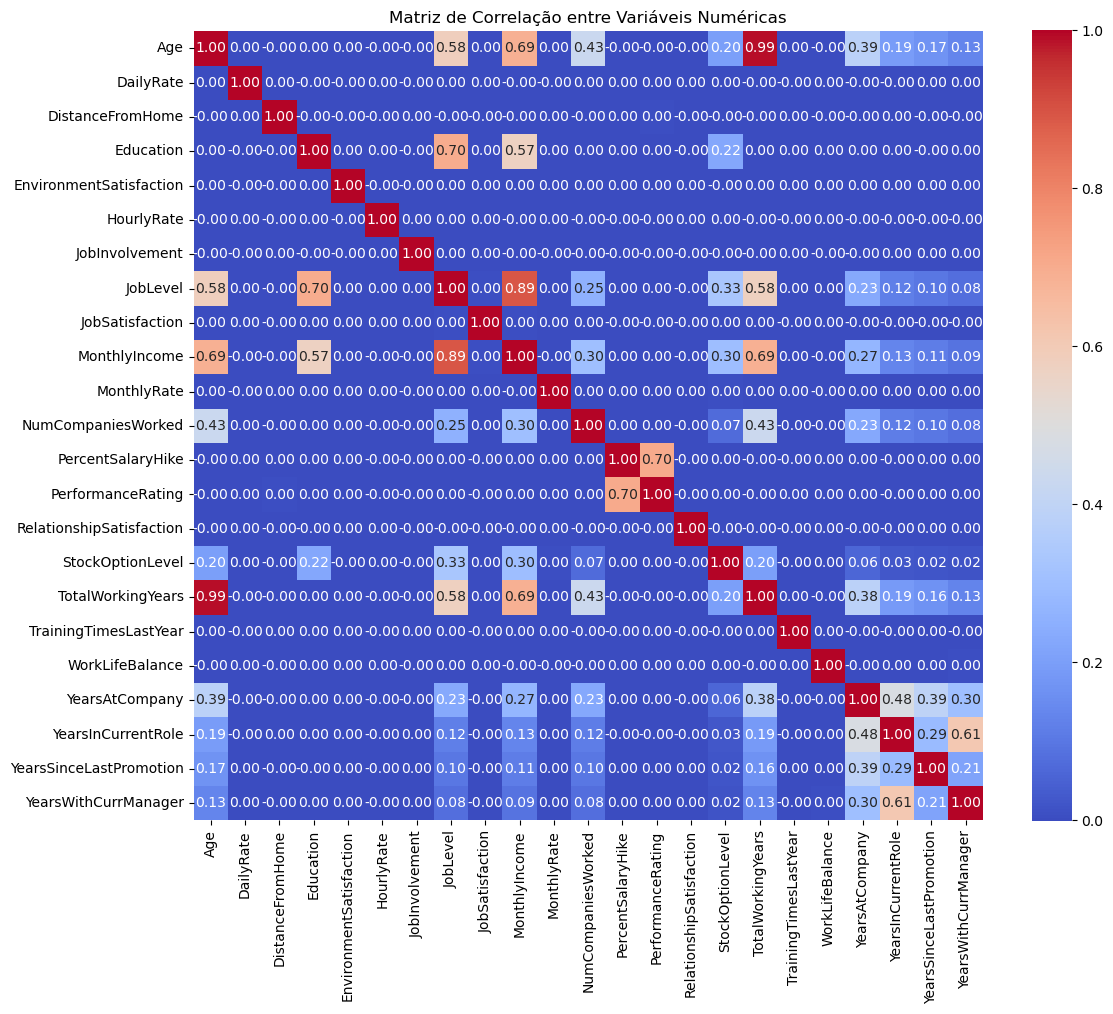

In [12]:
#Calcula a correlação entre todas as variáveis numéricas, gerando uma matriz que mostra como elas se relacionam entre si (de -1 a +1).
correlation_matrix = df[num_cols].corr()
#Identifica a correlação das variaveis númericas
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()



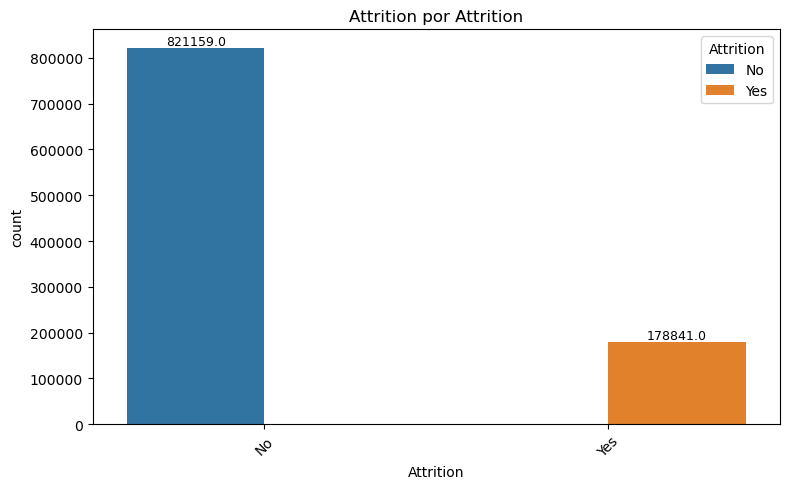

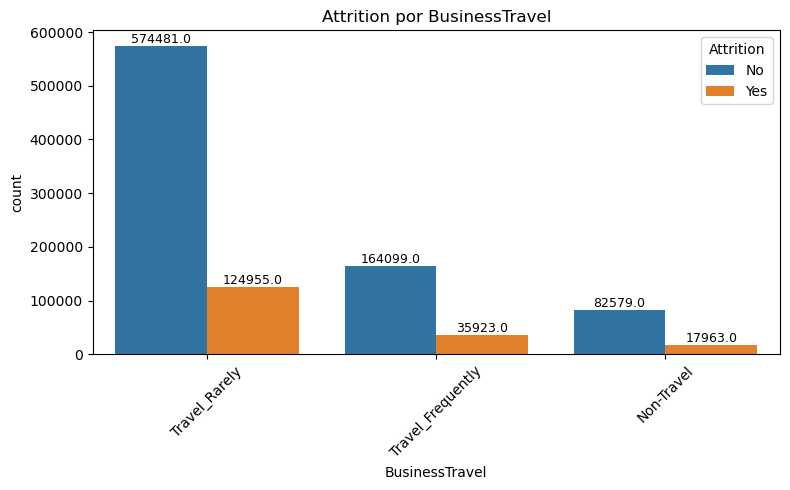

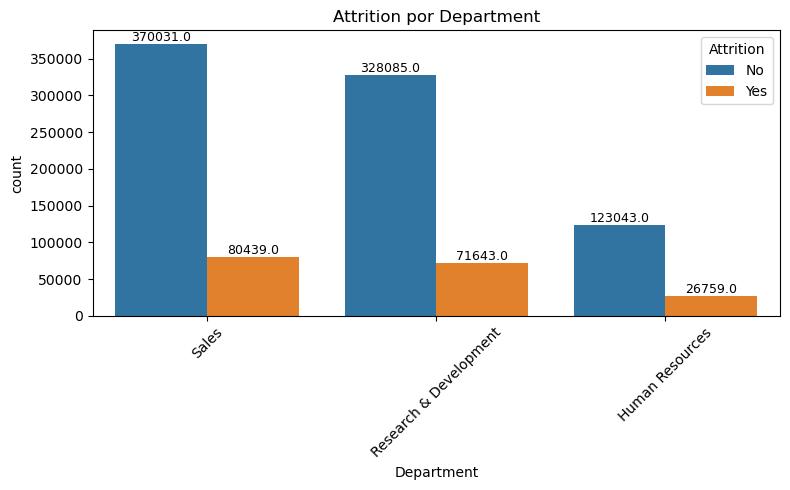

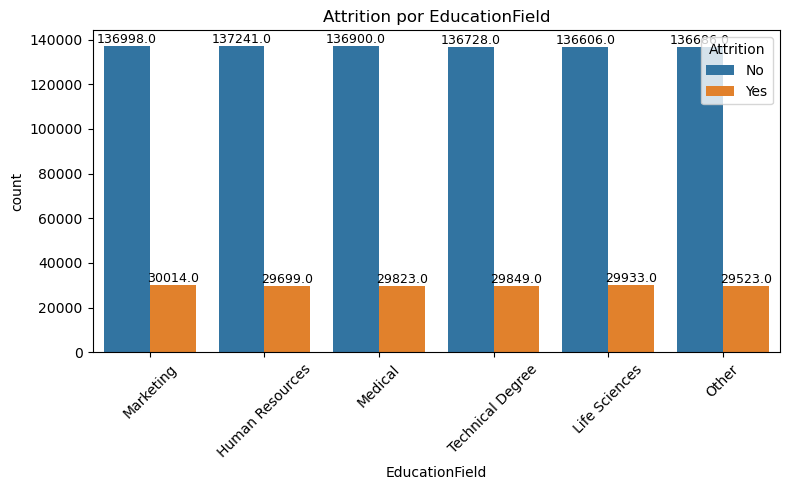

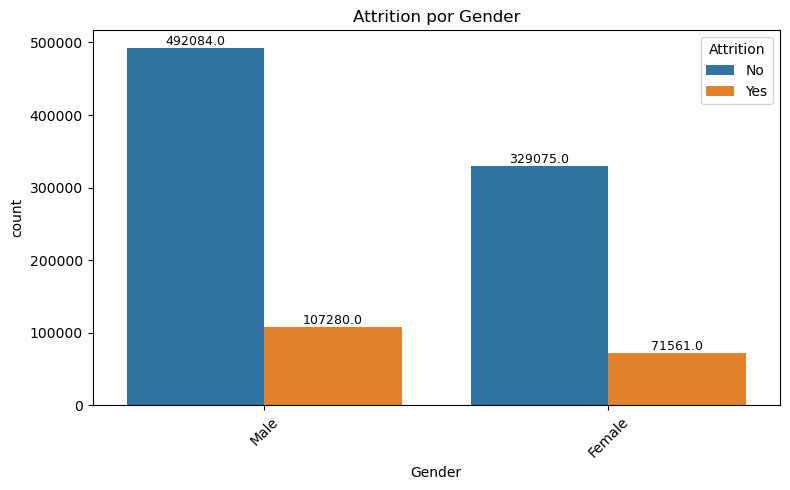

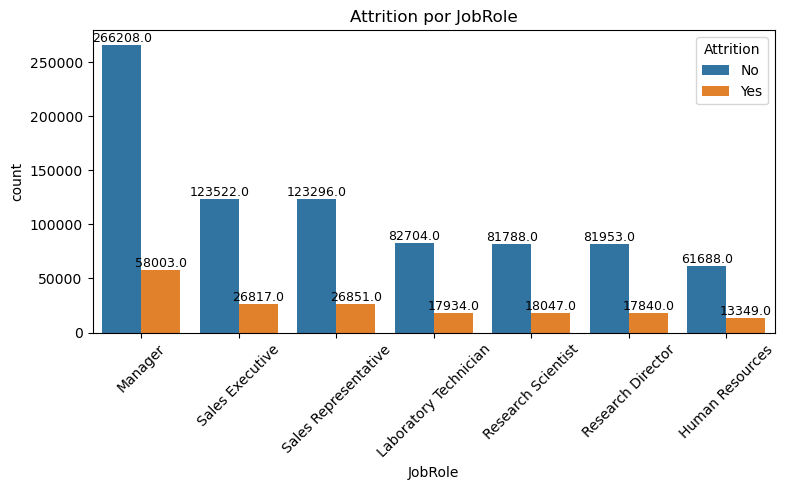

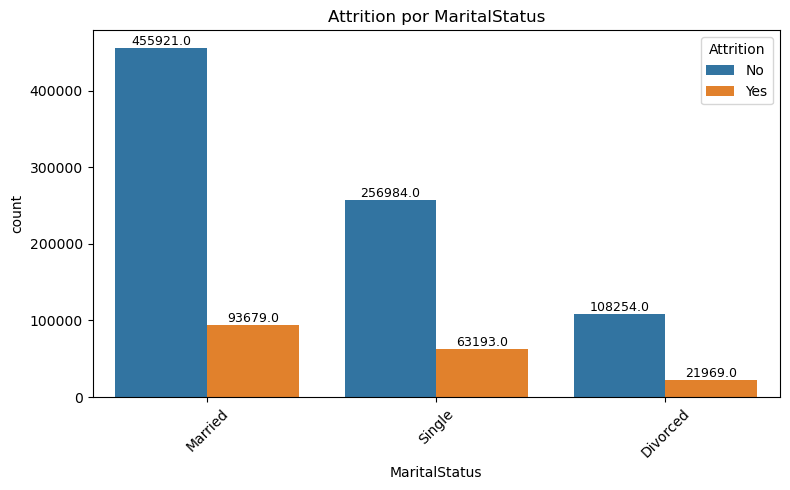

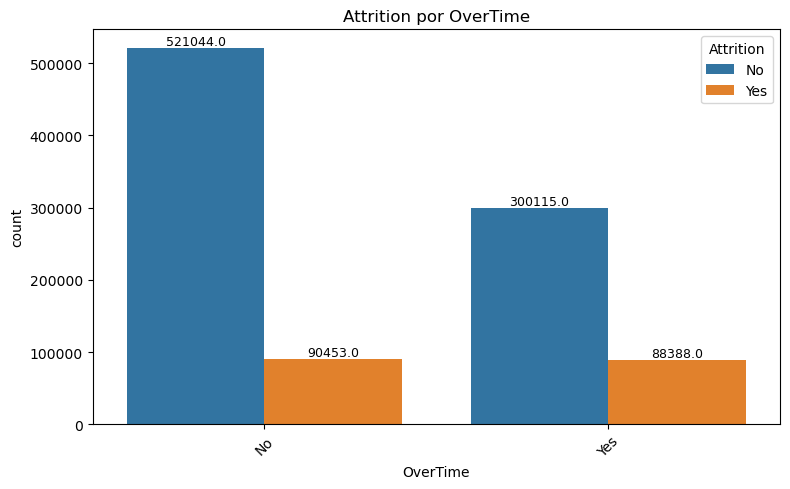

In [13]:
#Atritos das váriaveis categóricas
for col in cat_cols:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=col, hue='Attrition', data=df, order=df[col].value_counts().index)
    plt.title(f'Attrition por {col}')
    plt.xticks(rotation=45)

    # Adiciona os valores no topo de cada barra
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()



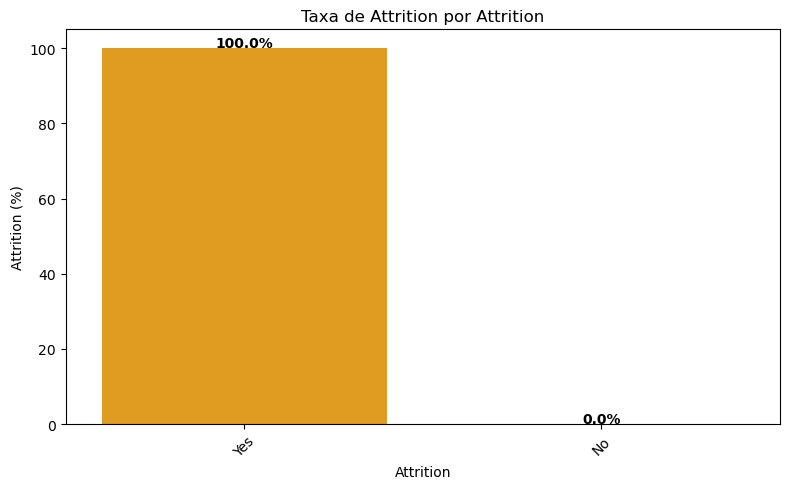

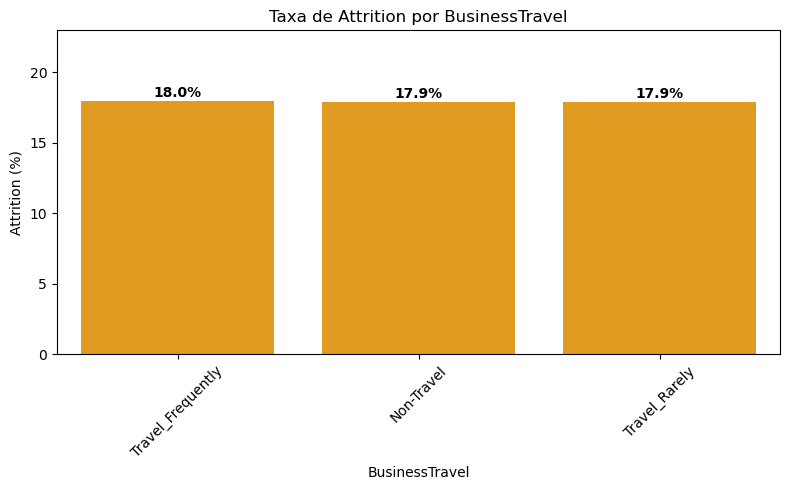

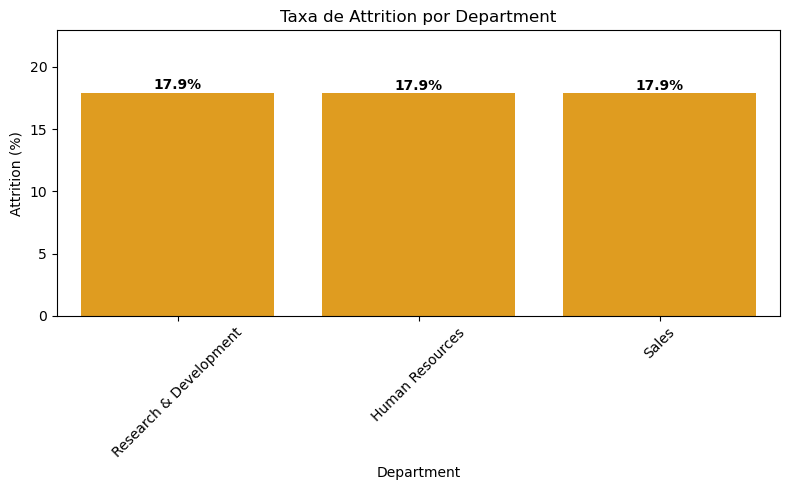

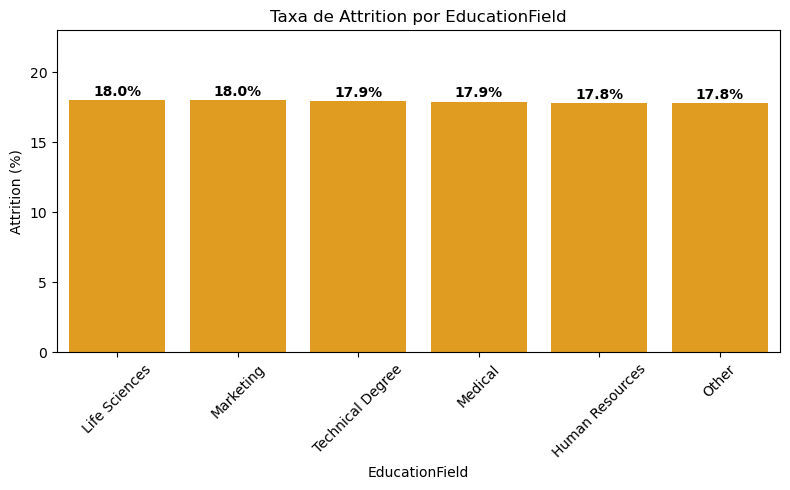

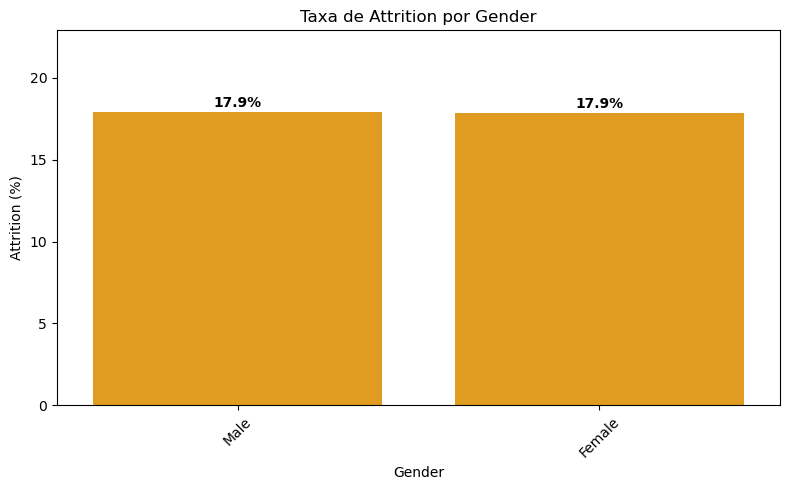

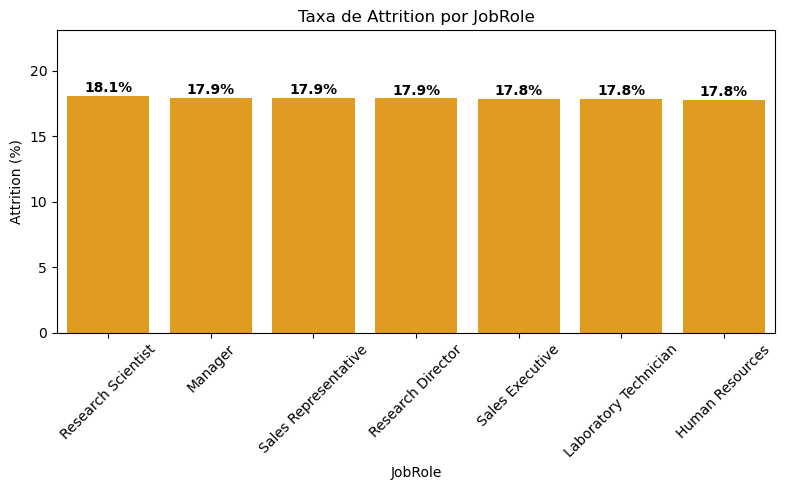

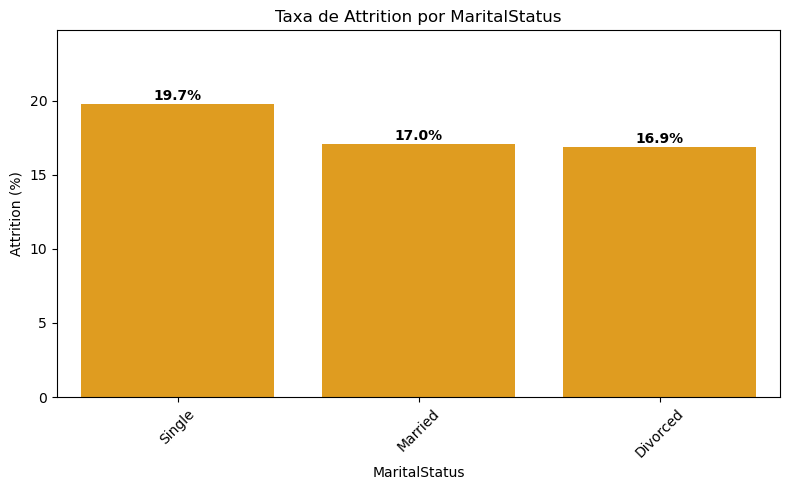

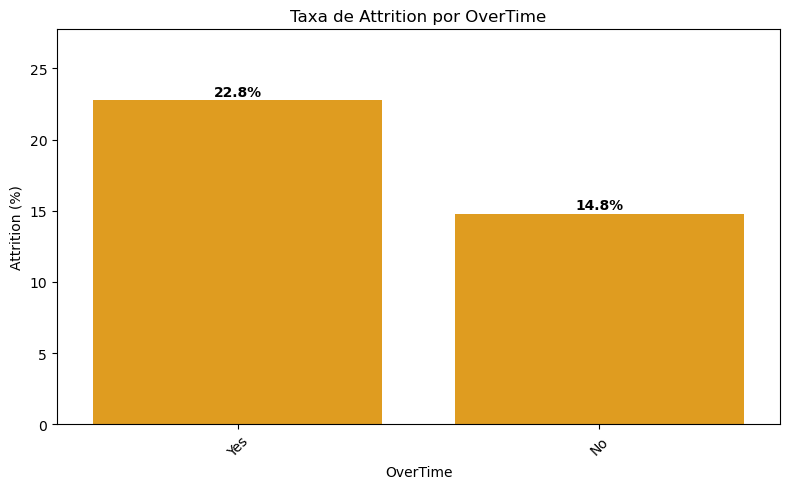

In [14]:
# Para variáveis categóricas com tamanhos diferentes entre os grupos, sempre use proporção (taxa) em vez de quantidade absoluta
#para analisar o attrition.


for cat_col in cat_cols:
    # Calcula a taxa de Attrition por categoria
    attrition_rate = pd.crosstab(df[cat_col], df['Attrition'], normalize='index') * 100

    # Ordena pela taxa 'Yes' (quem saiu)
    attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

    # Plota o gráfico
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], color='orange')

    # Adiciona os rótulos nas barras
    for i, v in enumerate(attrition_rate['Yes']):
        ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold')

    plt.ylim(0, attrition_rate['Yes'].max() + 5)
    plt.title(f'Taxa de Attrition por {cat_col}')
    plt.ylabel('Attrition (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

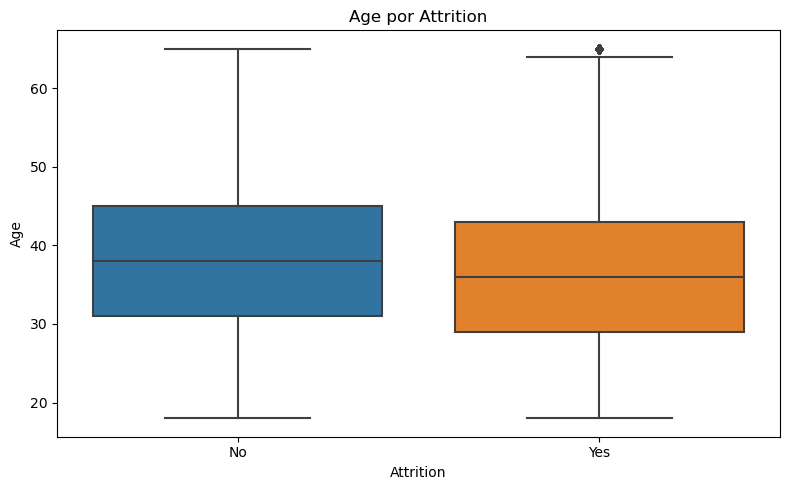

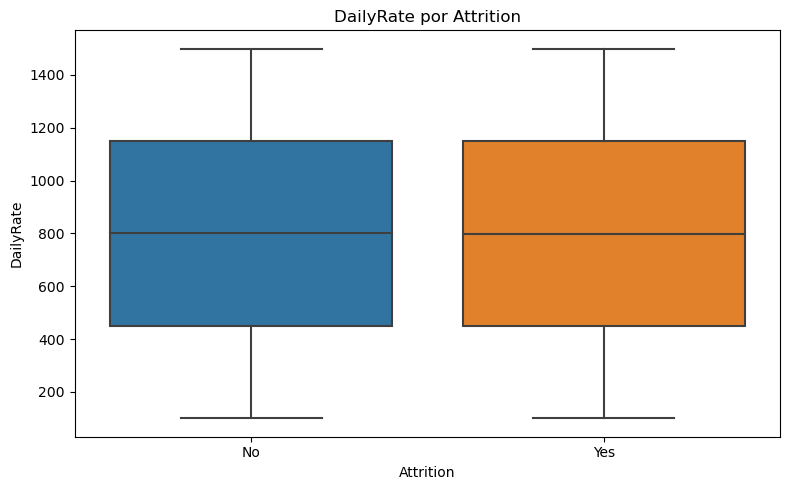

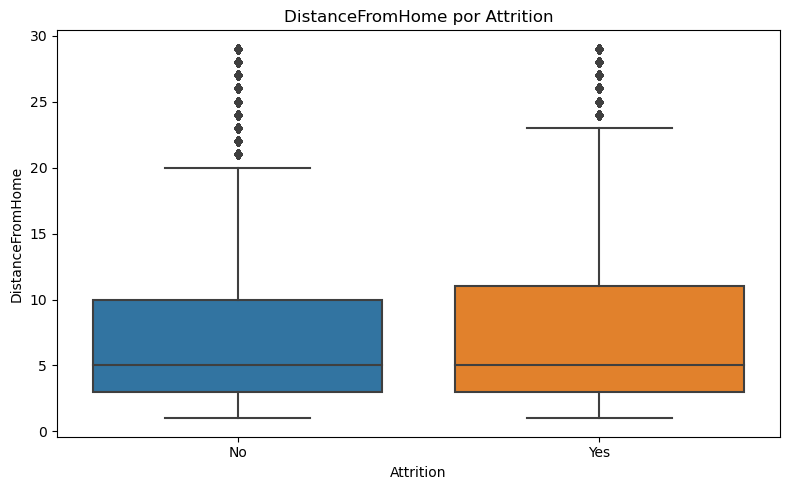

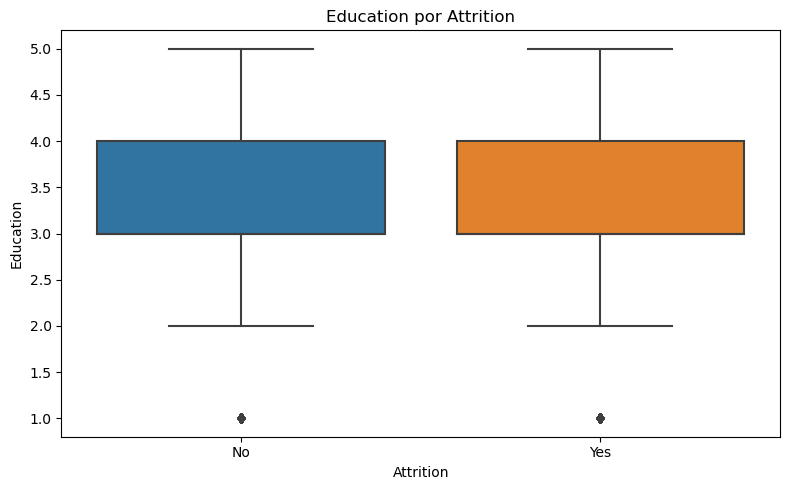

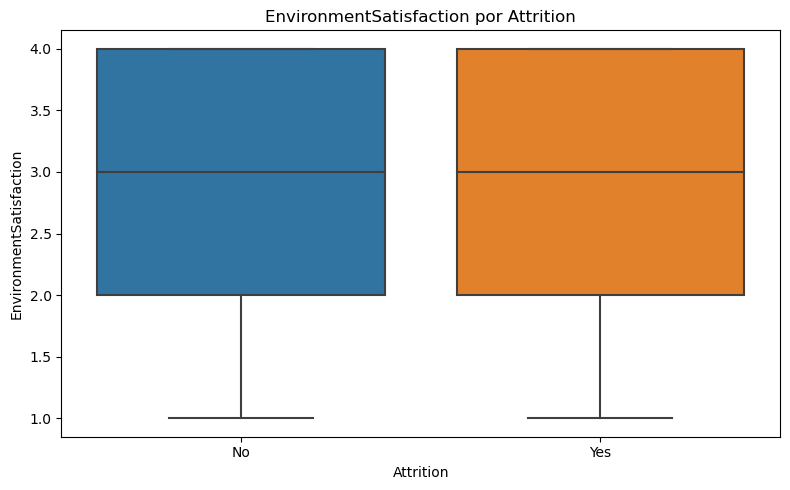

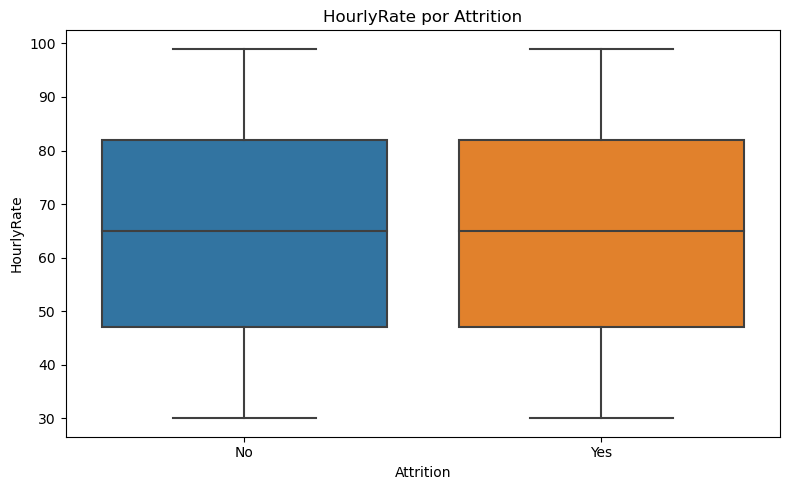

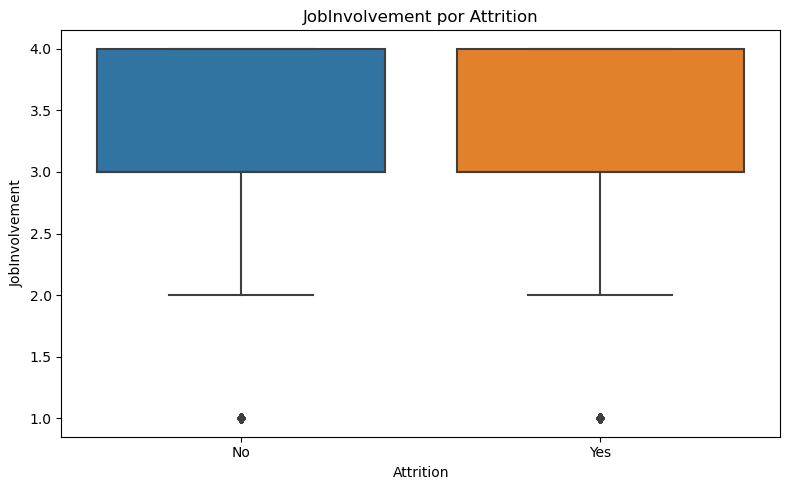

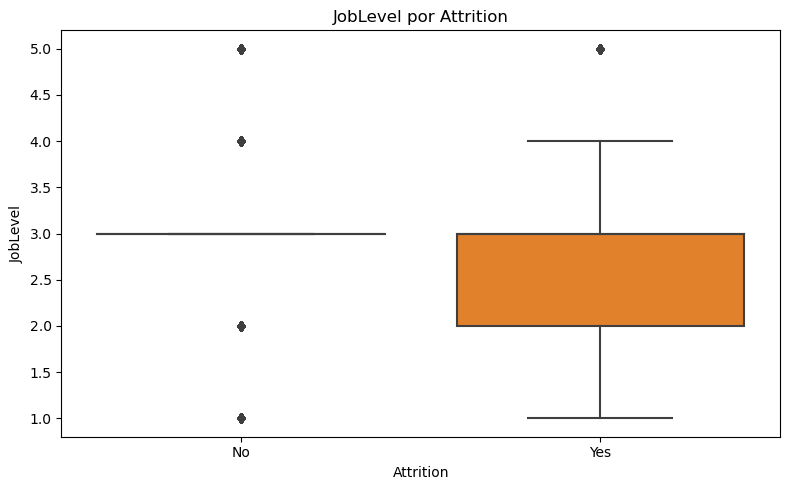

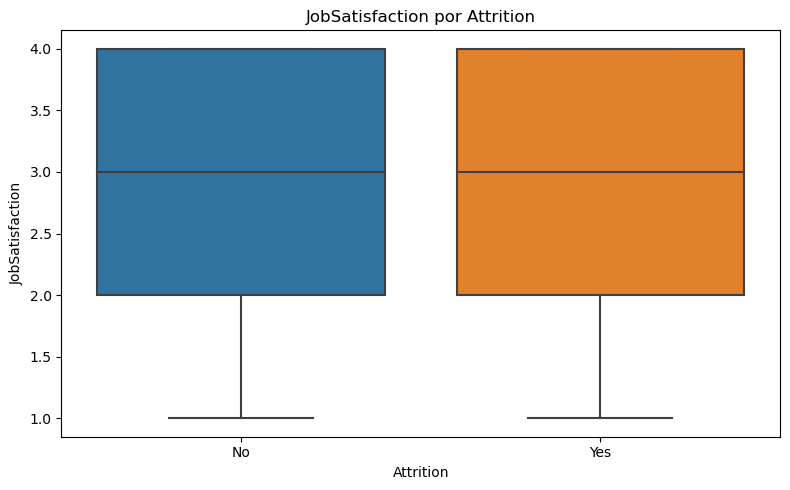

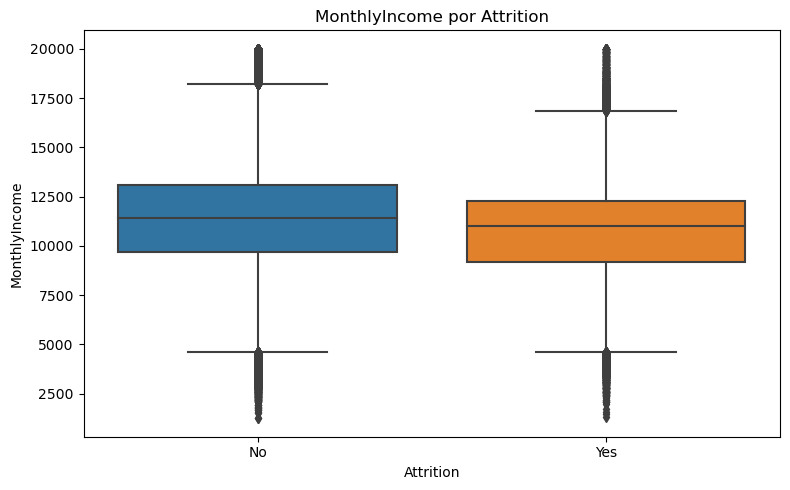

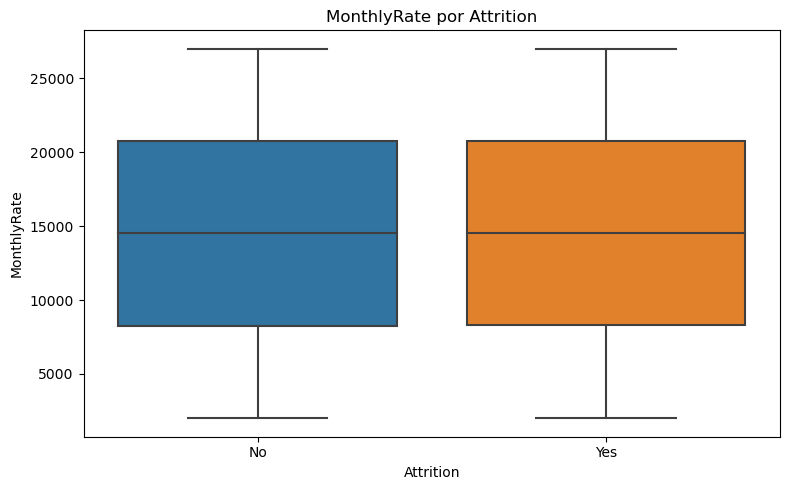

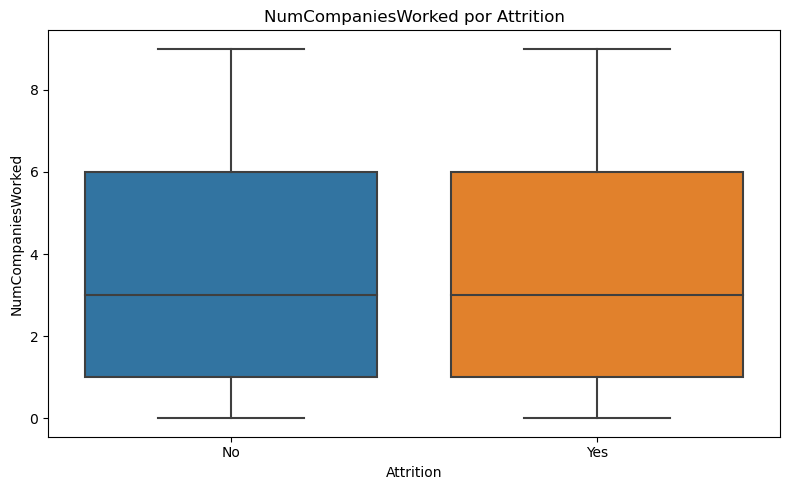

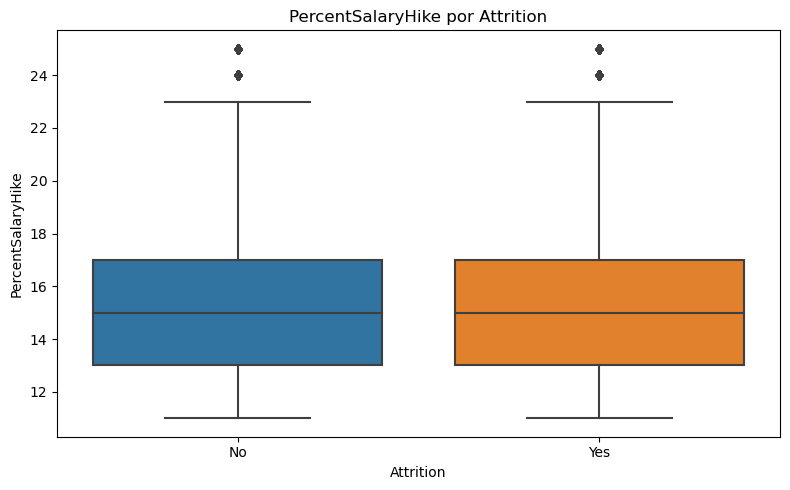

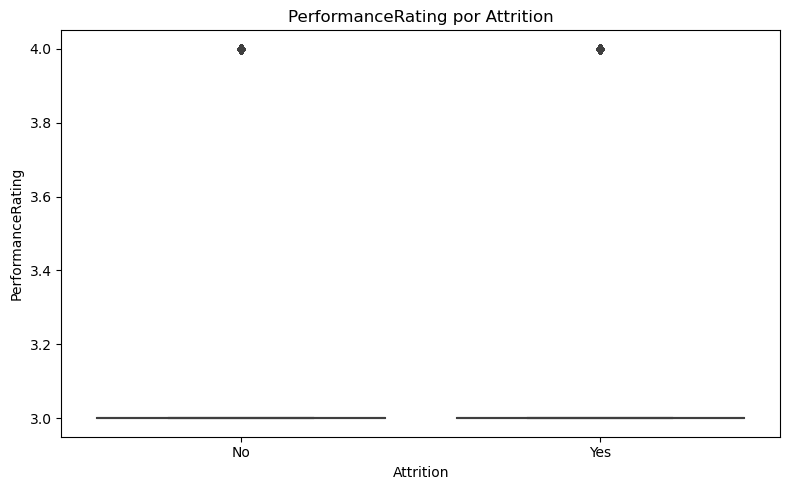

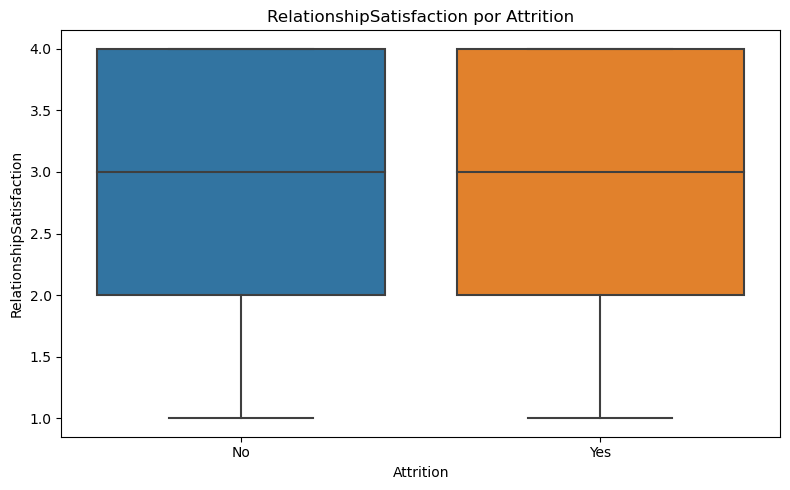

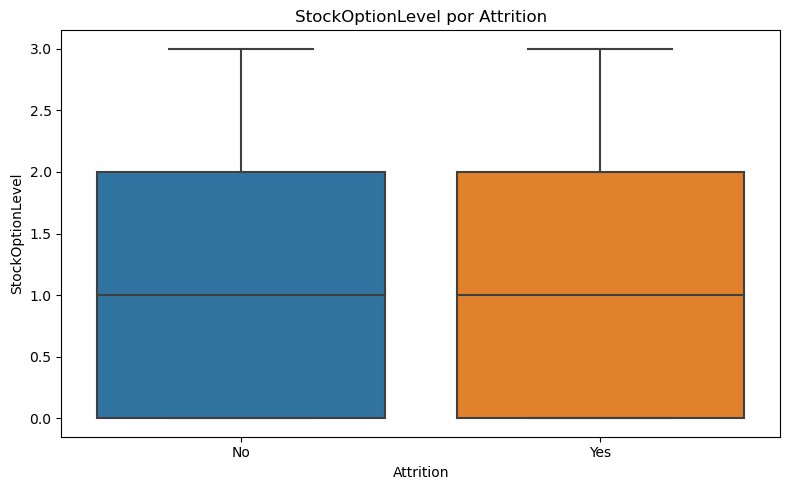

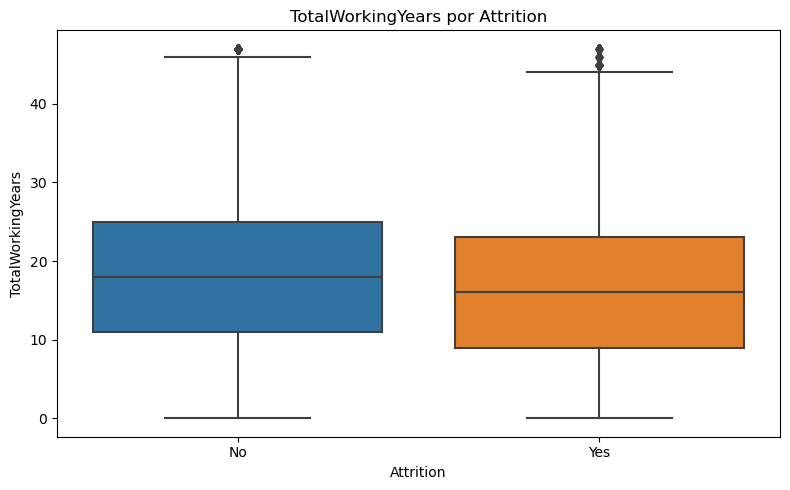

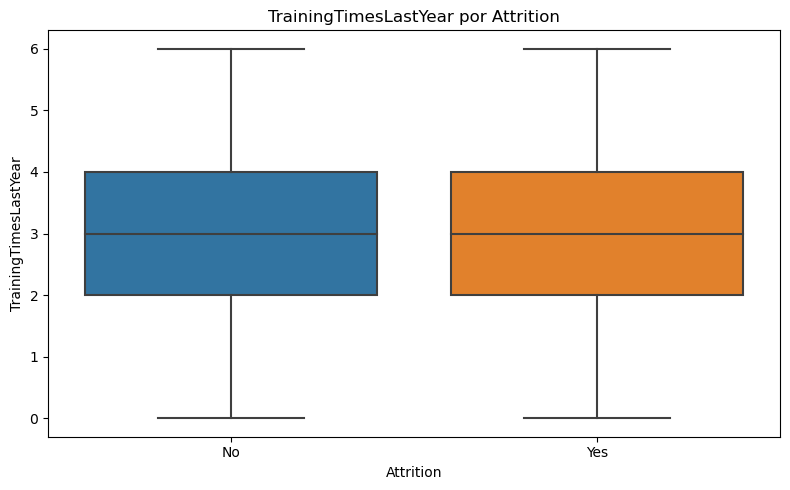

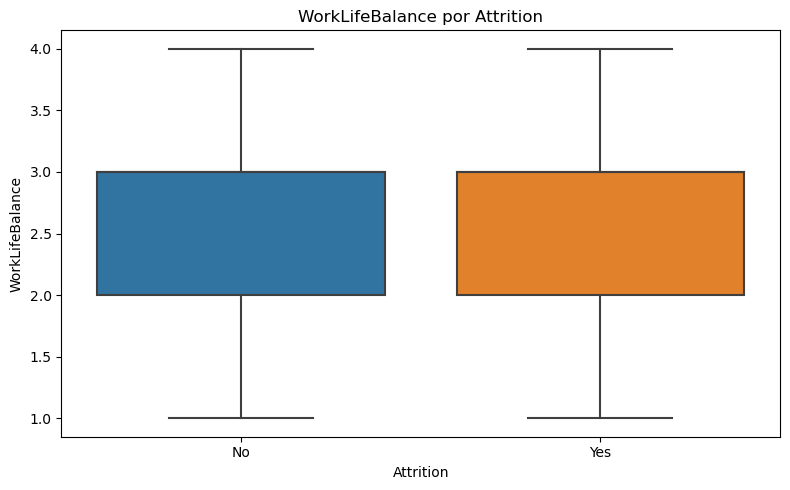

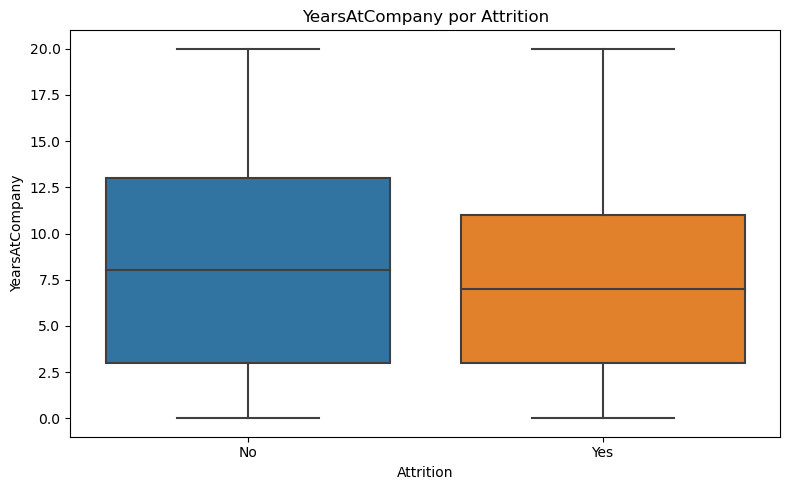

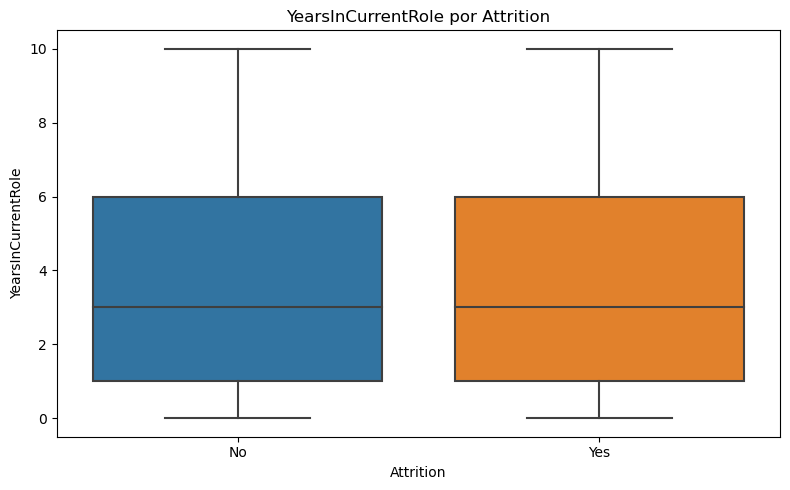

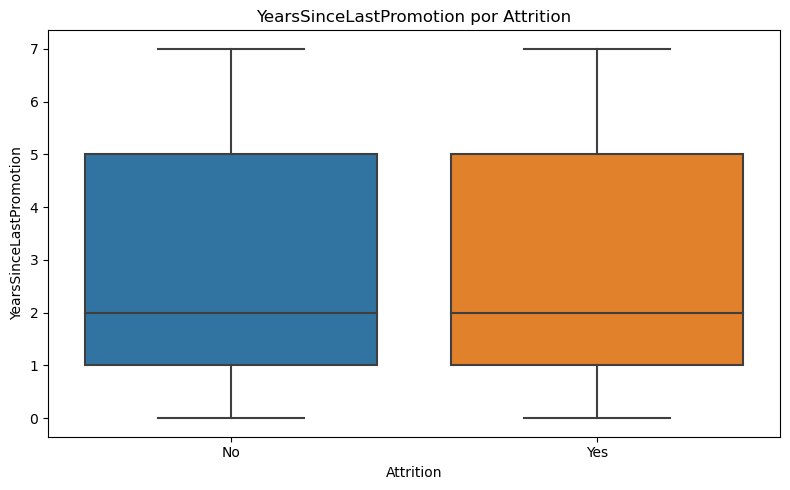

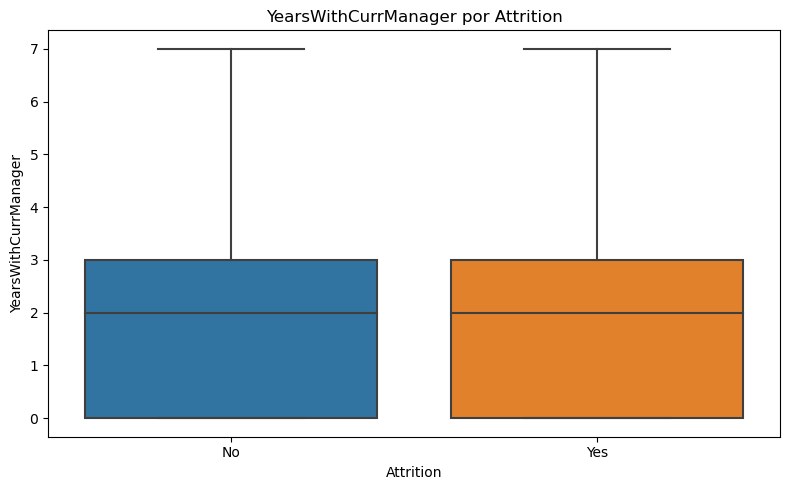

In [15]:
#Atritos das váriaveis númericas
for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Attrition', y=col, data=df)
    plt.title(f'{col} por Attrition')
    plt.tight_layout()
    plt.show()

###  Insights de negócio relevantes

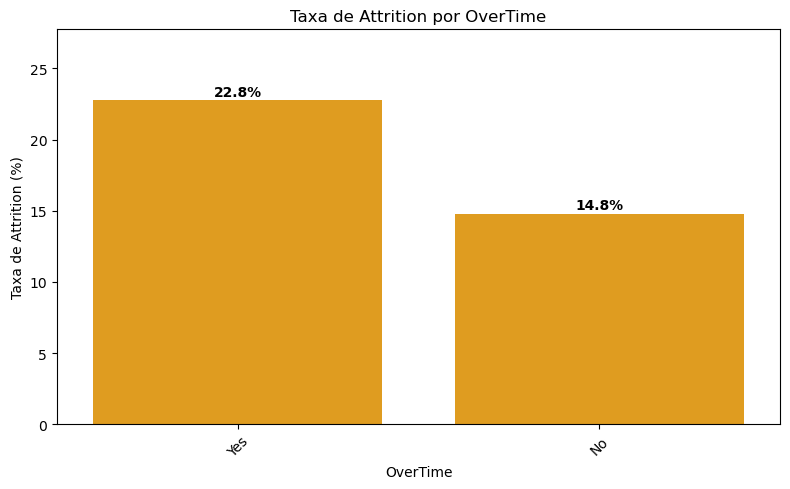

In [16]:
####Insights - Overtime(Horas Extras)
#Interpretação:
#Funcionários que fazem hora extra apresentam mais chances de sair da empresa. 

cat_col = 'OverTime'

# Tabela de proporções
attrition_rate = pd.crosstab(df[cat_col], df['Attrition'], normalize='index') * 100

# Ordena do maior para o menor
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

# Criação do gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], color='orange')

# Adiciona valores nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold')

plt.ylim(0, attrition_rate['Yes'].max() + 5)  # melhora o espaço
plt.ylabel('Taxa de Attrition (%)')
plt.title(f'Taxa de Attrition por {cat_col}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

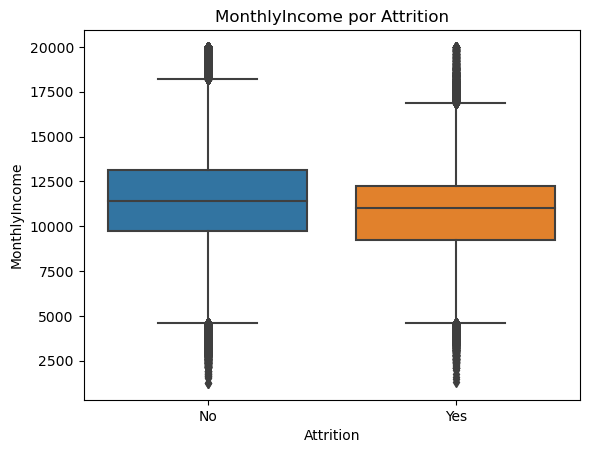

In [17]:
####Insights - Salário por Mês baseado no Atrition
#Interpretação:
#Se a caixa de Attrition = Yes estiver mais baixa, indica que pessoas com menor salário saem mais.

#Diferenças entre medianas também são um sinal claro.

#Outliers podem indicar exceções (ex: salários muito altos que também pediram demissão).


sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('MonthlyIncome por Attrition')
plt.show()

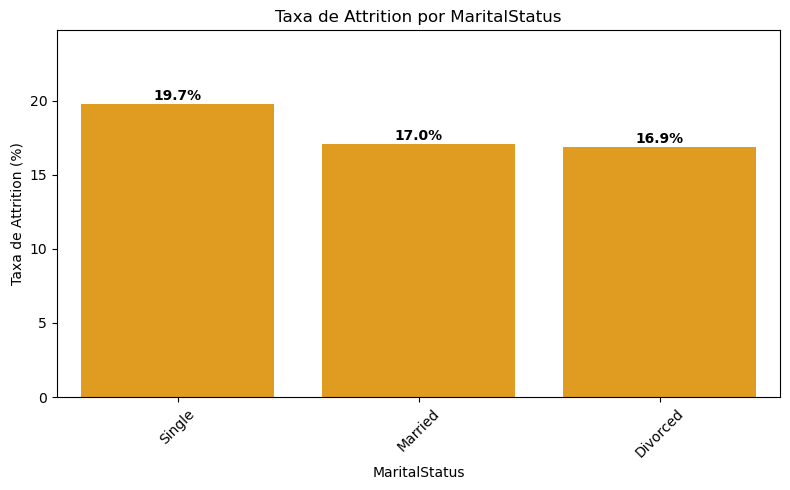

In [18]:
####Insights - MaritalStatus(Estado Cível)
#interpretação:
#Funcionários solteiros apresentam maior propensão ao desligamento.
#Isso pode estar ligado a maior mobilidade, menor comprometimento com estabilidade ou busca por novas oportunidades.

cat_col = 'MaritalStatus'

# Tabela de proporções
attrition_rate = pd.crosstab(df[cat_col], df['Attrition'], normalize='index') * 100

# Ordena do maior para o menor
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

# Criação do gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], color='orange')

# Adiciona valores nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold')

plt.ylim(0, attrition_rate['Yes'].max() + 5)  # melhora o espaço
plt.ylabel('Taxa de Attrition (%)')
plt.title(f'Taxa de Attrition por {cat_col}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

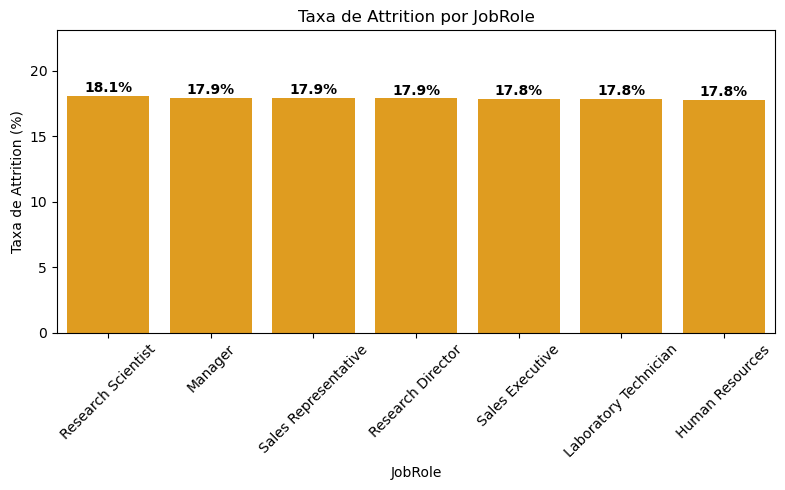

In [19]:
###Insights - JobRole(Cargo)
#Interpretaçaõ:
#Não há grande variação de attrition entre os cargos, porém se destaca o cargo de Research Scientist
cat_col = 'JobRole'

# Tabela de proporções
attrition_rate = pd.crosstab(df[cat_col], df['Attrition'], normalize='index') * 100

# Ordena do maior para o menor
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

# Criação do gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], color='orange')

# Adiciona valores nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold')

plt.ylim(0, attrition_rate['Yes'].max() + 5)  # melhora o espaço
plt.ylabel('Taxa de Attrition (%)')
plt.title(f'Taxa de Attrition por {cat_col}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Feature Engineering

In [20]:
#Feature - Tempo com gerente em relação ao tempo total
df['RatioWithManager'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)  # +1 para evitar divisão por zero

In [21]:
#Interpretação:

#Valor da RatioWithManager	Significado
#Perto de 1.0	Está com o mesmo gerente desde que entrou na empresa
#Perto de 0.0	Está há pouco tempo com o gerente (pode ser instável)
#Médio (0.4 ~ 0.7)	Gerente mudou no meio do caminho

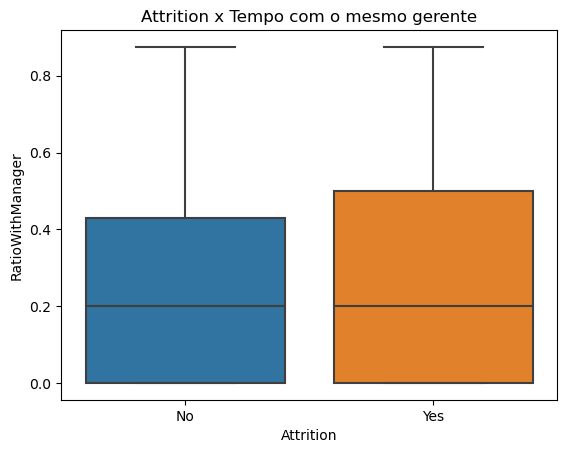

In [22]:
sns.boxplot(x='Attrition', y='RatioWithManager', data=df)
plt.title('Attrition x Tempo com o mesmo gerente')
plt.show()

In [23]:
#-------------------------------------------------------------------------------------

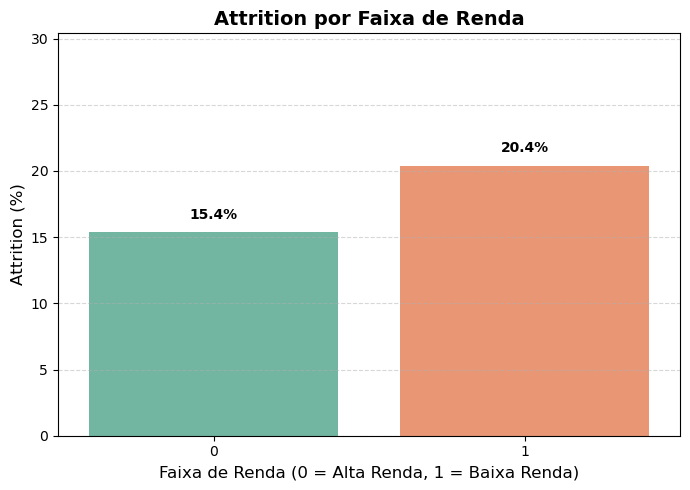

In [24]:
####Feature - Faixa da Renda
#Interpretação:
#O gráfico mostra que funcionários de baixa renda (1) têm uma maior taxa de saída (attrition) do que os de alta renda (0).
#20,4% dos funcionários de baixa renda saíram da empresa
#Contra 15,4% dos de alta renda

# Definir um limiar de baixa renda (ex: abaixo da mediana)
income_threshold = df['MonthlyIncome'].median()

# Criar a feature binária
df['LowIncomeFlag'] = (df['MonthlyIncome'] < income_threshold).astype(int)

# Calcular proporção de attrition por faixa de renda
attrition_rate = pd.crosstab(df['LowIncomeFlag'], df['Attrition'], normalize='index') * 100

# Organizar visualmente
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x=attrition_rate.index,
    y=attrition_rate['Yes'],
    palette='Set2'
)

# Adicionar rótulos nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Títulos e rótulos
plt.title('Attrition por Faixa de Renda', fontsize=14, fontweight='bold')
plt.xlabel('Faixa de Renda (0 = Alta Renda, 1 = Baixa Renda)', fontsize=12)
plt.ylabel('Attrition (%)', fontsize=12)
plt.ylim(0, attrition_rate['Yes'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


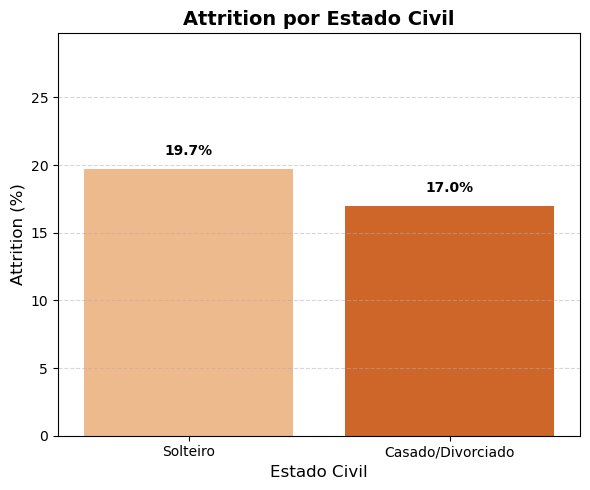

In [25]:
####Feature - MaritalStatus(Estado Cível)
#interpretação:
#Funcionários solteiros apresentam maior propensão ao desligamento.
#Isso pode estar ligado a maior mobilidade, menor comprometimento com estabilidade ou busca por novas oportunidades.

df['IsSingle'] = (df['MaritalStatus'] == 'Single').astype(int)

# Tabela de proporções
attrition_rate = pd.crosstab(df['IsSingle'], df['Attrition'], normalize='index') * 100

# Ordena do maior para o menor
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)
#Grafico
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    x=attrition_rate.index.map({0: 'Casado/Divorciado', 1: 'Solteiro'}), 
    y=attrition_rate['Yes'], 
    palette='Oranges'
)

# Adicionar valores nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Estilização
plt.ylim(0, attrition_rate['Yes'].max() + 10)
plt.title('Attrition por Estado Civil', fontsize=14, fontweight='bold')
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Attrition (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

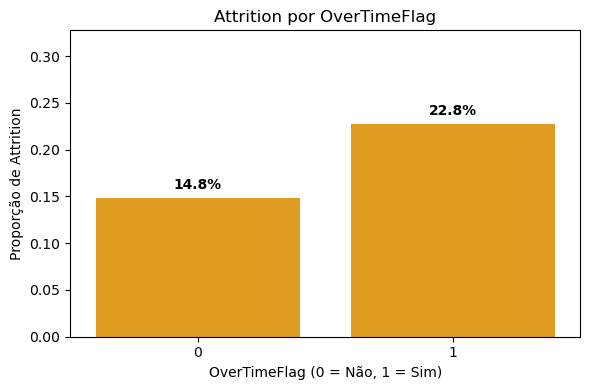

In [26]:
####Feature - Overtime(Horas Extras)
#Interpretação:
#Funcionários que fazem hora extra apresentam mais chances de sair da empresa. 
df['OverTimeFlag'] = (df['OverTime'] == 'Yes').astype(int)

# Preparar dados para visualização
df_plot = df.replace({'Attrition': {'Yes': 1, 'No': 0}})
attrition_by_overtime = df_plot.groupby('OverTimeFlag')['Attrition'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='OverTimeFlag', y='Attrition', data=attrition_by_overtime, color='orange')

# Adicionar os rótulos de porcentagem
for i, v in enumerate(attrition_by_overtime['Attrition']):
    ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

# Personalização
plt.title('Attrition por OverTimeFlag')
plt.ylabel('Proporção de Attrition')
plt.xlabel('OverTimeFlag (0 = Não, 1 = Sim)')
plt.ylim(0, attrition_by_overtime['Attrition'].max() + 0.1)
plt.tight_layout()
plt.show()

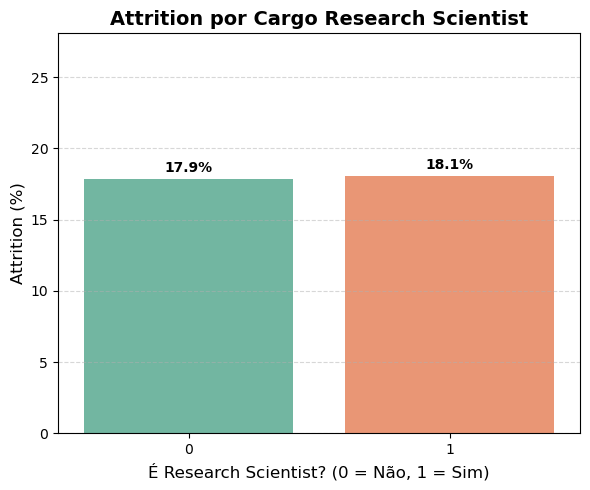

In [27]:
###Feature - JobRole(Cargo)
#Interpretaçaõ:
#Não há grande variação de attrition entre os cargos, porém se destaca o cargo de Research Scientist
df['IsResearchScientist'] = (df['JobRole'] == 'Research Scientist').astype(int)

# Calcular proporções de attrition por grupo
attrition_rate = pd.crosstab(df['IsResearchScientist'], df['Attrition'], normalize='index') * 100

# Plotar
plt.figure(figsize=(6, 5))
ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], palette='Set2')

# Adicionar rótulos nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Ajustes de rótulo e layout
plt.title('Attrition por Cargo Research Scientist', fontsize=14, fontweight='bold')
plt.xlabel('É Research Scientist? (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Attrition (%)', fontsize=12)
plt.ylim(0, attrition_rate['Yes'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
###Feature - Satisfação total das variaveis ambiente, relacionamento, equilíbrio vida-trabalho e satisfação com o cargo 
df['SatisfactionIndex'] = (
    df['JobSatisfaction'] +
    df['EnvironmentSatisfaction'] +
    df['RelationshipSatisfaction'] +
    df['WorkLifeBalance']
) / 4


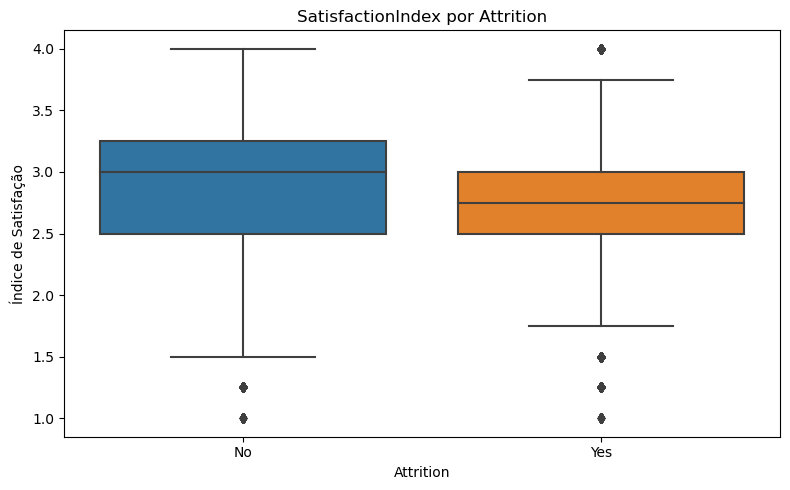

In [29]:
#Interpretação:
#Funcionários com menor índice de satisfação geral apresentam maior propensão a sair da empresa.
#Isso indica que fatores como ambiente, relacionamento, equilíbrio vida-trabalho e satisfação com 
#o cargo impactam diretamente a retenção.
plt.figure(figsize=(8, 5))
sns.boxplot(x='Attrition', y='SatisfactionIndex', data=df)
plt.title('SatisfactionIndex por Attrition')
plt.ylabel('Índice de Satisfação')
plt.tight_layout()
plt.show()

In [30]:
#Possível Feature -Risco de Burnout
df['BurnoutRisk'] = ((df['OverTime'] == 'Yes') & (df['SatisfactionIndex'] < 3)).astype(int)

#A coluna BurnoutRisk foi definida como:
#1 (Sim) → Funcionários que fazem hora extra (OverTime == 'Yes') e possuem baixo índice de satisfação (SatisfactionIndex < 3)
#0 (Não) → Todos os demais funcionário


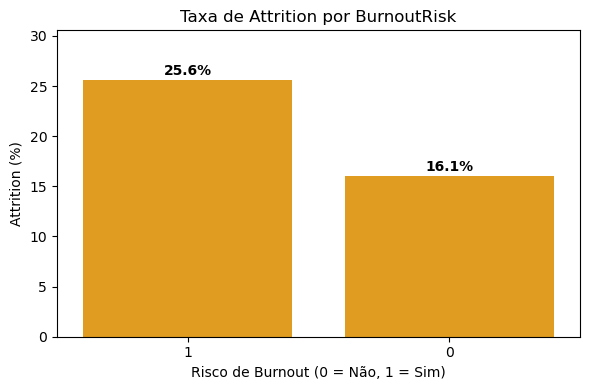

In [31]:
#Interpretação:

#Funcionários que apresentam sinais de risco de burnout 
#(ou seja, trabalham em regime de hora extra e estão insatisfeitos) 
#possuem uma taxa de saída significativamente mais alta:
#25,6% contra 16,1%.


# Cria gráfico de taxa de attrition para a variável binária BurnoutRisk
attrition_rate = pd.crosstab(df['BurnoutRisk'], df['Attrition'], normalize='index') * 100
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=attrition_rate.index.astype(str), y=attrition_rate['Yes'], color='orange')

# Adiciona rótulos
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.ylabel('Attrition (%)')
plt.xlabel('Risco de Burnout (0 = Não, 1 = Sim)')
plt.title('Taxa de Attrition por BurnoutRisk')
plt.ylim(0, attrition_rate['Yes'].max() + 5)
plt.tight_layout()
plt.show()

In [32]:
#Feature - Grupo por idade
df['AgeGroup'] = pd.cut(df['Age'],bins=[16, 30, 45, 60, 100],labels=['Jovem', 'Adulto', 'Meia-idade', 'Senhor'], include_lowest=True
)

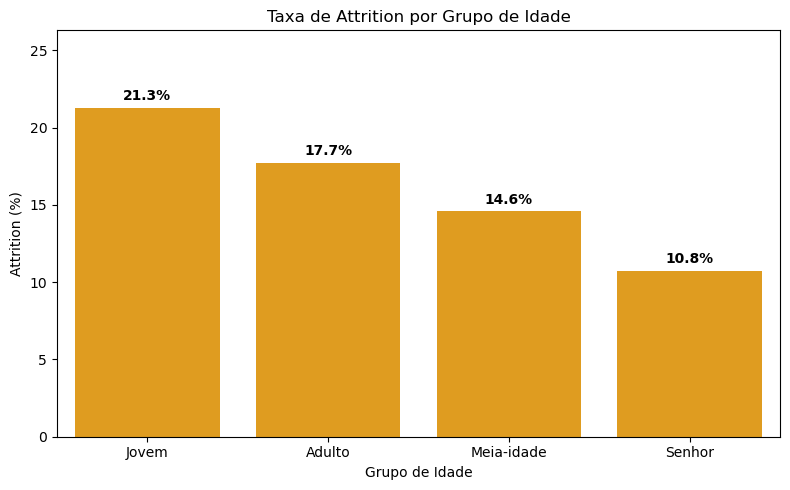

In [33]:
### Interpretação:
#Jovens têm maior tendência a sair da empresa: Com uma taxa de 21,3%, é o grupo com maior atrito. 
#Pode indicar instabilidade, busca por crescimento rápido ou insatisfação.


# Cálculo da taxa de Attrition por faixa etária
attrition_rate = pd.crosstab(df['AgeGroup'], df['Attrition'], normalize='index') * 100
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

# Gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], color='orange')

# Adiciona os rótulos de porcentagem nas barras
for i, v in enumerate(attrition_rate['Yes']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.title('Taxa de Attrition por Grupo de Idade')
plt.ylabel('Attrition (%)')
plt.xlabel('Grupo de Idade')
plt.ylim(0, attrition_rate['Yes'].max() + 5)
plt.tight_layout()
plt.show()

In [34]:
#Feature - Relação entre tempo na empresa e tempo total de trabalho.
df['TenureRatio'] = df['YearsAtCompany'] / df['TotalWorkingYears'].replace(0, np.nan)
# Remover valores NaN resultantes de divisão por 0 (se houver)
#df = df.dropna(subset=['TenureRatio'])
df['TenureRatio'] = df['TenureRatio'].fillna(0)


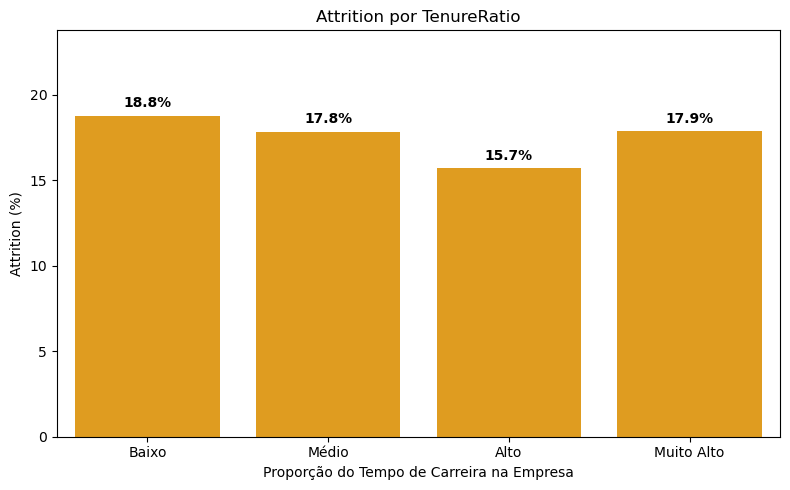

In [35]:
#Interpretação:
#Quanto menor o tempo relativo de carreira na empresa, maior o risco de saída.

# Agrupando a variável em faixas para visualização
df['TenureRatioGroup'] = pd.cut(df['TenureRatio'], 
                                bins=[0, 0.25, 0.5, 0.75, 1.0],
                                labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])

# Calculando a taxa de attrition por grupo
attrition_rate = pd.crosstab(df['TenureRatioGroup'], df['Attrition'], normalize='index') * 100
attrition_rate = attrition_rate.sort_values(by='Yes', ascending=False)

# Ordena os grupos na ordem original de faixas
order = ['Baixo', 'Médio', 'Alto', 'Muito Alto']

# Gráfico corrigido
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=attrition_rate.index, y=attrition_rate['Yes'], color='orange', order=order)

# Adiciona os rótulos nas barras
for i, v in enumerate(attrition_rate.loc[order]['Yes']):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

plt.ylabel('Attrition (%)')
plt.xlabel('Proporção do Tempo de Carreira na Empresa')
plt.title('Attrition por TenureRatio')
plt.ylim(0, attrition_rate['Yes'].max() + 5)
plt.tight_layout()
plt.show()

In [36]:
####Feature - Stock Options(Beneficios corporativo)
#Valor	Significado
#Nenhum	Nenhuma opção de de beneficio
#Baixo	Nível básico de stock option
#2 e 3	Nível médio e alto
df['StockOptionCategory'] = pd.cut(df['StockOptionLevel'],bins=[-1, 0, 1, 3],  labels=['Nenhum', 'Baixo', 'Alto'])

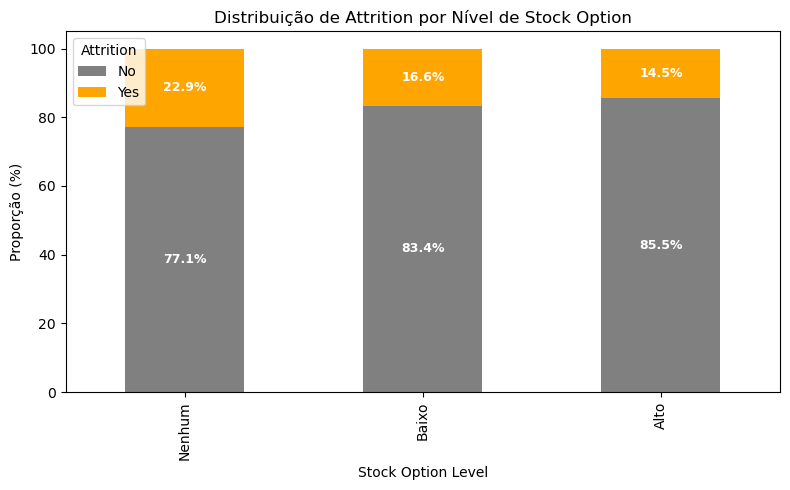

In [37]:
###Interprete:
#A oferta de stock options parece ter efeito direto na retenção:
#Funcionários com benefícios de longo prazo (como ações da empresa) tendem a permanecer mais tempo.
#Isso sugere que ações são um fator importante de engajamento.


# Calcula a tabela de proporções
attrition_crosstab = pd.crosstab(df['StockOptionCategory'], df['Attrition'], normalize='index') * 100

# Cria o gráfico
ax = attrition_crosstab.plot(
    kind='bar',
    stacked=True,
    color=['gray', 'orange'],
    figsize=(8, 5)
)

# Adiciona os rótulos de porcentagem em cada segmento
for i, (idx, row) in enumerate(attrition_crosstab.iterrows()):
    bottom = 0
    for attrition_status in ['No', 'Yes']:
        value = row[attrition_status]
        if value > 0:
            ax.text(i, bottom + value / 2, f'{value:.1f}%', ha='center', va='center', fontsize=9, color='white', fontweight='bold')
        bottom += value

# Ajustes do gráfico
plt.title('Distribuição de Attrition por Nível de Stock Option')
plt.ylabel('Proporção (%)')
plt.xlabel('Stock Option Level')
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()

### Polynomial feature

In [38]:
#Polynomial feature - Baseado nas colunas Age, MonthlyIncome e Tuneratio
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['Age', 'MonthlyIncome', 'TenureRatio']])
feature_names = poly.get_feature_names_out(['Age', 'MonthlyIncome', 'TenureRatio'])

In [39]:
X_poly

array([[4.20000000e+01, 1.13800000e+04, 2.08333333e-01, ...,
        1.29504400e+08, 2.37083333e+03, 4.34027778e-02],
       [3.60000000e+01, 1.34550000e+04, 9.44444444e-01, ...,
        1.81037025e+08, 1.27075000e+04, 8.91975309e-01],
       [4.40000000e+01, 1.39180000e+04, 9.09090909e-01, ...,
        1.93710724e+08, 1.26527273e+04, 8.26446281e-01],
       ...,
       [3.60000000e+01, 1.20110000e+04, 5.62500000e-01, ...,
        1.44264121e+08, 6.75618750e+03, 3.16406250e-01],
       [5.20000000e+01, 1.35510000e+04, 5.80645161e-01, ...,
        1.83629601e+08, 7.86832258e+03, 3.37148803e-01],
       [4.20000000e+01, 1.04250000e+04, 1.00000000e-01, ...,
        1.08680625e+08, 1.04250000e+03, 1.00000000e-02]])

In [40]:
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
X_poly_df.head()

,Age,MonthlyIncome,TenureRatio,Age^2,Age MonthlyIncome,Age TenureRatio,MonthlyIncome^2,MonthlyIncome TenureRatio,TenureRatio^2
0,42.0,11380.0,0.208333,1764.0,477960.0,8.750000,129504400.0,2370.833333,0.043403
1,36.0,13455.0,0.944444,1296.0,484380.0,34.000000,181037025.0,12707.500000,0.891975
2,44.0,13918.0,0.909091,1936.0,612392.0,40.000000,193710724.0,12652.727273,0.826446
3,53.0,12201.0,0.096774,2809.0,646653.0,5.129032,148864401.0,1180.741935,0.009365
4,35.0,14647.0,0.823529,1225.0,512645.0,28.823529,214534609.0,12062.235294,0.678201


In [41]:
#Interprete:
#| Feature                       | Correlação com Attrition | Interpretação Rápida                     |
#| ----------------------------- | ------------------------ | ---------------------------------------- |
#| `TenureRatio`                 | **+0.0025**              | Quase nenhuma correlação com atrito.     |
#| `TenureRatio^2`               | **+0.0021**              | Correlação ainda muito fraca.            |
#| `MonthlyIncome * TenureRatio` | **+0.0020**              | Quase nula também.                       |
#| `Age * TenureRatio`           | **+0.0019**              | Muito fraca.                             |
#| `MonthlyIncome^2`             | **+0.0015**              | Sem impacto relevante.                   |
#| `Age^2`                       | **-0.0015**              | Inversamente muito pouco correlacionada. |
#| `Age * MonthlyIncome`         | **-0.0016**              | Quase nada.                              |
#| `MonthlyIncome`               | **-0.0017**              | Quase nada.                              |

X_poly_df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1})
X_poly_df.corr()['Attrition'].sort_values(ascending=False)

Attrition                    1.000000
TenureRatio^2               -0.006971
TenureRatio                 -0.014785
MonthlyIncome TenureRatio   -0.043357
Age TenureRatio             -0.044927
Age                         -0.065667
Age^2                       -0.066125
Age MonthlyIncome           -0.084609
MonthlyIncome               -0.086183
MonthlyIncome^2             -0.090816
Name: Attrition, dtype: float64

####  Embedding

In [42]:
encoder = OrdinalEncoder()
df['AgeGroup_encoded'] = encoder.fit_transform(df[['AgeGroup']]).astype(int)

# Descobrir quantas categorias únicas foram codificadas
n_categories = df['AgeGroup_encoded'].nunique()

In [43]:
# Entrada
age_input = Input(shape=(1,))
age_embedding = Embedding(input_dim=n_categories, output_dim=2)(age_input)
age_vector = Flatten()(age_embedding)

# Saída
output = Dense(1, activation='sigmoid')(age_vector)
model = Model(inputs=age_input, outputs=output)

In [44]:
# Compilação
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [45]:
# Ajuste: garantir que X esteja no formato certo (array ou Series com shape=(n,1))
X_age = df['AgeGroup_encoded'].values.reshape(-1, 1)
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # se necessário

# Treinamento
model.fit(X_age, y, epochs=10, batch_size=32)

# Embedding aplicado à variável categórica AgeGroup
# A rede neural simples foi treinada para mapear cada grupo etário ('Jovem', 'Adulto', etc.)
# em um vetor denso (2D), otimizando para prever a variável alvo Attrition (0 ou 1).
# O modelo alcançou ~82% de acurácia usando apenas AgeGroup como entrada

Epoch 1/10
31250/31250 [==============================] - 26s 827us/step - loss: 0.4690 - accuracy: 0.8212
Epoch 2/10
31250/31250 [==============================] - 22s 706us/step - loss: 0.4679 - accuracy: 0.8212
Epoch 3/10
31250/31250 [==============================] - 19s 624us/step - loss: 0.4679 - accuracy: 0.8212
Epoch 4/10
31250/31250 [==============================] - 19s 610us/step - loss: 0.4678 - accuracy: 0.8212
Epoch 5/10
31250/31250 [==============================] - 20s 652us/step - loss: 0.4678 - accuracy: 0.8212
Epoch 6/10
31250/31250 [==============================] - 20s 642us/step - loss: 0.4678 - accuracy: 0.8212
Epoch 7/10
31250/31250 [==============================] - 20s 640us/step - loss: 0.4678 - accuracy: 0.8212
Epoch 8/10
31250/31250 [==============================] - 20s 627us/step - loss: 0.4678 - accuracy: 0.8212
Epoch 9/10
31250/31250 [==============================] - 20s 651us/step - loss: 0.4678 - accuracy: 0.8212
Epoch 10/10
31250/31250 [============

### Bloco de separação dos modelos X, Y e Features

In [46]:
# Separar features e target
X = original_df.drop('Attrition', axis=1)


In [47]:
# Separar features e target
Y = original_df['Attrition'].map({'Yes': 1, 'No': 0})

In [48]:
#Acrescentar as features em um DataFrame especifico
X_eng = X.copy()
#Feature 1
X_eng['RatioWithManager'] = X_eng['YearsWithCurrManager'] / (X_eng['YearsAtCompany'] + 1) 
#Feature 2
X_eng['SatisfactionIndex'] = ( X_eng['JobSatisfaction'] + X_eng['EnvironmentSatisfaction'] + X_eng['RelationshipSatisfaction'] + X_eng['WorkLifeBalance'] ) / 4
#Feature 3
X_eng['BurnoutRisk'] = ((X_eng['OverTime'] == 'Yes') & (X_eng['SatisfactionIndex'] < 3)).astype(int)
#Feature 4
X_eng['AgeGroup'] = pd.cut(X_eng['Age'],bins=[16, 30, 45, 60, 100],labels=['Jovem', 'Adulto', 'Meia-idade', 'Senhor'],include_lowest=True
)
#Feature 5
X_eng['TenureRatio'] = X_eng['YearsAtCompany'] / X_eng['TotalWorkingYears'].replace(0, np.nan)
X_eng['TenureRatio'] = X_eng['TenureRatio'].fillna(0)
#Feature 6
X_eng['StockOptionCategory'] = pd.cut(X_eng['StockOptionLevel'],bins=[-1, 0, 1, 3],  labels=['Nenhum', 'Baixo', 'Alto'])
#Feature 7
X_eng['OverTimeFlag'] = (X_eng['OverTime'] == 'Yes').astype(int)
#Feature 8
income_threshold = X_eng['MonthlyIncome'].median()
X_eng['LowIncomeFlag'] = (X_eng['MonthlyIncome'] < income_threshold).astype(int)
#Feature 9
X_eng['IsSingle'] = (X_eng['MaritalStatus'] == 'Single').astype(int)
#Feature 10
X_eng['IsResearchScientist'] = (X_eng['JobRole'] == 'Research Scientist').astype(int)


#Feature 11- Acrescentar as features de Técnicas Avançadas - Polynomial features
# 1. Gerar as polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_eng[['Age', 'MonthlyIncome', 'TenureRatio']])

# 2. Pegar os nomes das novas features
feature_names = poly.get_feature_names_out(['Age', 'MonthlyIncome', 'TenureRatio'])

# 3. Criar um DataFrame com as polynomial features
df_poly = pd.DataFrame(X_poly, columns=feature_names, index=X_eng.index)

# 4. Concatenar com o seu DataFrame X_eng
X_eng = pd.concat([X_eng, df_poly], axis=1)

#Feature 12 - Acrescentar as features de Técnicas Avançadas - Embeddings

# 1. Codificar AgeGroup
encoder = OrdinalEncoder()
X_eng['AgeGroup_encoded'] = encoder.fit_transform(X_eng[['AgeGroup']]).astype(int)

# 2. Criar modelo para treinar embedding (input_dim = nº de categorias)
input_dim = X_eng['AgeGroup_encoded'].nunique()
embedding_dim = 2

# Definir entrada e embedding
age_input = Input(shape=(1,))
age_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=1)(age_input)
age_vector = Flatten()(age_embedding)

# Modelo apenas para gerar o vetor denso (não é um modelo final preditivo)
embedding_model = Model(inputs=age_input, outputs=age_vector)

# 3. Gerar o vetor de embedding para todos os registros
age_embeddings = embedding_model.predict(X_eng[['AgeGroup_encoded']])

# 4. Adicionar os vetores ao DataFrame
for i in range(embedding_dim):
    X_eng[f'AgeGroup_emb_{i}'] = age_embeddings[:, i]
    



31250/31250 [==============================] - 15s 474us/step


In [49]:
# Remove colunas duplicadas de forma mais eficiente
X_eng = X_eng.loc[:, ~X_eng.columns.duplicated()]

##  Modelagem

In [50]:
# X: dataframe de features com engenharia,polynomias e embeddings
# y: variável target binária
x_treino = X_eng.copy()
y_treino = original_df['Attrition'].map({'Yes': 1, 'No': 0})

In [51]:
# 2. Separar colunas por tipo
numeric_features  = X_eng.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
categorical_features = X_eng.select_dtypes(include=['object', 'category']).columns.tolist()

In [52]:
# 3. Transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

In [53]:
# 4. Pré-processador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [54]:
# 5. Pipeline com modelo
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_jobs=-1, verbose=1, random_state=42))
])

In [55]:
# 6. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(x_treino, y_treino, test_size=0.2, random_state=42)



🔍 Treinando modelo: Random Forest
Fitting 3 folds for each of 8 candidates, totalling 24 fits

📋 Classification Report:
              precision    recall  f1-score   support

       Ficou       0.94      0.16      0.27    164300
        Saiu       0.20      0.96      0.33     35700

    accuracy                           0.30    200000
   macro avg       0.57      0.56      0.30    200000
weighted avg       0.81      0.30      0.28    200000



<Figure size 400x400 with 0 Axes>

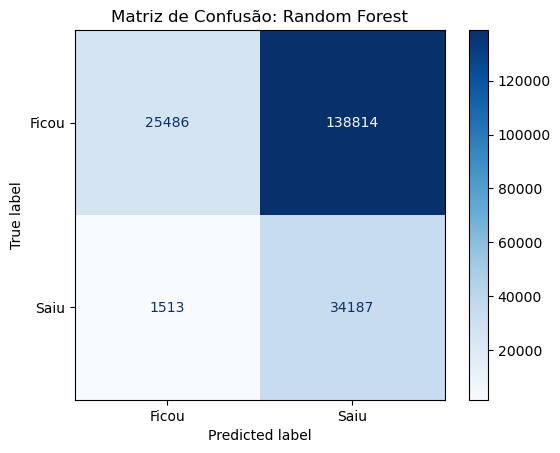


📊 Métricas específicas:
Precision: 0.1976
Recall: 0.9576
F1-Score: 0.3276
F2-Score: 0.5413
Balanced Accuracy: 0.5564
MCC: 0.1263
Precision-Recall AUC: 0.2929


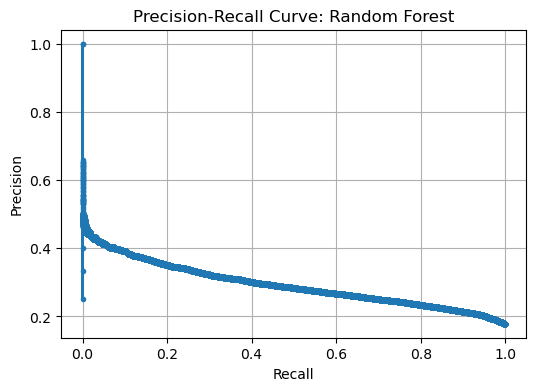

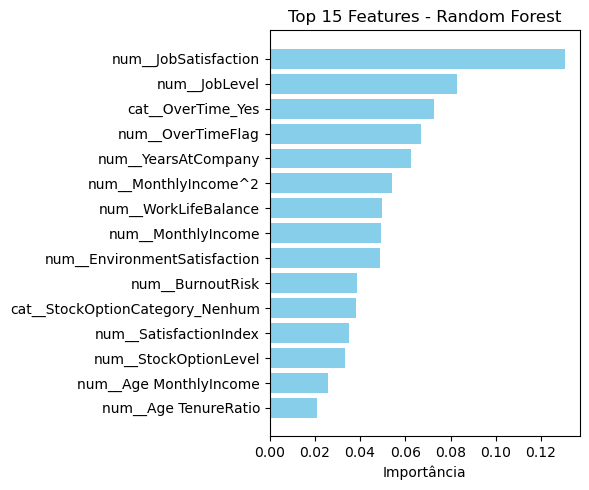


🎯 Fairness por: Department
Sales: Recall = 0.958, Precision = 0.195
Research & Development: Recall = 0.956, Precision = 0.200
Human Resources: Recall = 0.961, Precision = 0.200

🎯 Fairness por: MaritalStatus
Divorced: Recall = 0.959, Precision = 0.186
Married: Recall = 0.952, Precision = 0.191
Single: Recall = 0.965, Precision = 0.213

🎯 Fairness por: JobRole
Sales Representative: Recall = 0.956, Precision = 0.193
Manager: Recall = 0.960, Precision = 0.200
Research Director: Recall = 0.958, Precision = 0.195
Sales Executive: Recall = 0.956, Precision = 0.196
Research Scientist: Recall = 0.953, Precision = 0.201
Human Resources: Recall = 0.959, Precision = 0.198
Laboratory Technician: Recall = 0.956, Precision = 0.199

🎯 Fairness por: Gender
Male: Recall = 0.958, Precision = 0.199
Female: Recall = 0.957, Precision = 0.195

🎯 Fairness por: BusinessTravel
Non-Travel: Recall = 0.958, Precision = 0.199
Travel_Frequently: Recall = 0.958, Precision = 0.199
Travel_Rarely: Recall = 0.957, Prec

<Figure size 400x400 with 0 Axes>

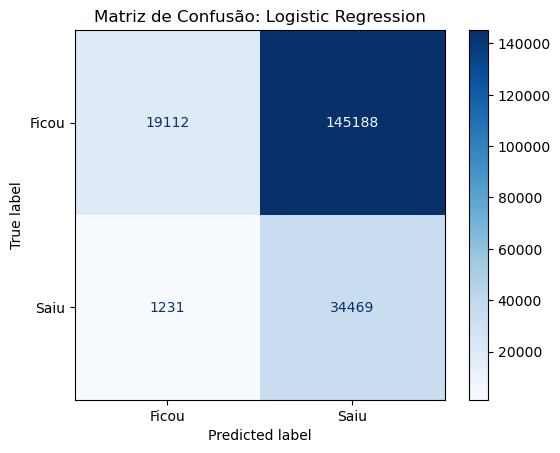


📊 Métricas específicas:
Precision: 0.1919
Recall: 0.9655
F1-Score: 0.3201
F2-Score: 0.5345
Balanced Accuracy: 0.5409
MCC: 0.1037
Precision-Recall AUC: 0.2710


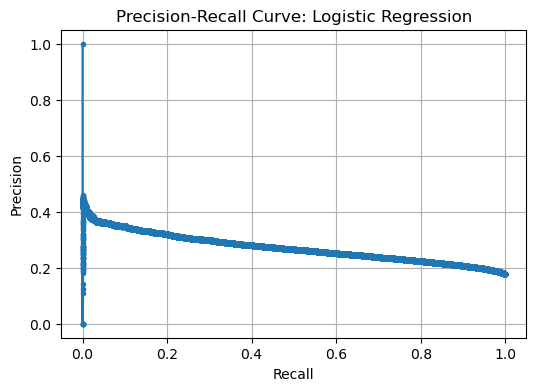

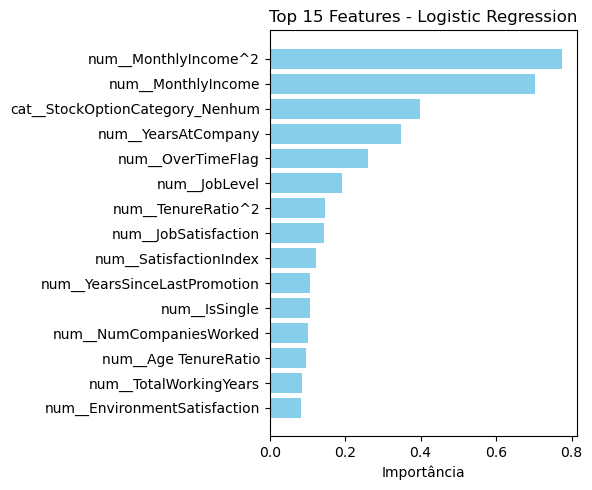


🎯 Fairness por: Department
Sales: Recall = 0.965, Precision = 0.189
Research & Development: Recall = 0.964, Precision = 0.194
Human Resources: Recall = 0.969, Precision = 0.195

🎯 Fairness por: MaritalStatus
Divorced: Recall = 0.958, Precision = 0.182
Married: Recall = 0.958, Precision = 0.186
Single: Recall = 0.979, Precision = 0.206

🎯 Fairness por: JobRole
Sales Representative: Recall = 0.964, Precision = 0.187
Manager: Recall = 0.968, Precision = 0.194
Research Director: Recall = 0.966, Precision = 0.189
Sales Executive: Recall = 0.963, Precision = 0.190
Research Scientist: Recall = 0.962, Precision = 0.195
Human Resources: Recall = 0.968, Precision = 0.193
Laboratory Technician: Recall = 0.964, Precision = 0.194

🎯 Fairness por: Gender
Male: Recall = 0.966, Precision = 0.194
Female: Recall = 0.964, Precision = 0.189

🎯 Fairness por: BusinessTravel
Non-Travel: Recall = 0.963, Precision = 0.193
Travel_Frequently: Recall = 0.965, Precision = 0.193
Travel_Rarely: Recall = 0.966, Prec

<Figure size 400x400 with 0 Axes>

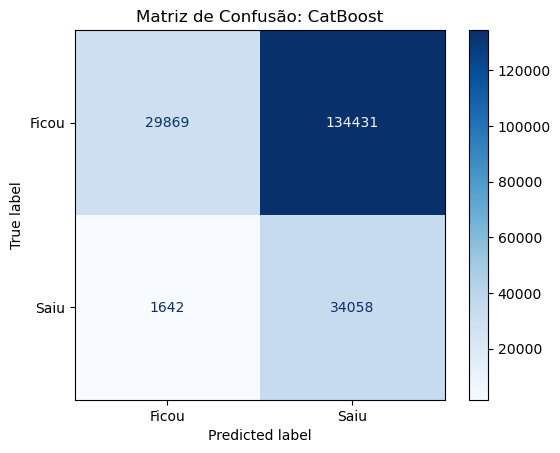


📊 Métricas específicas:
Precision: 0.2021
Recall: 0.9540
F1-Score: 0.3336
F2-Score: 0.5470
Balanced Accuracy: 0.5679
MCC: 0.1427
Precision-Recall AUC: 0.3008


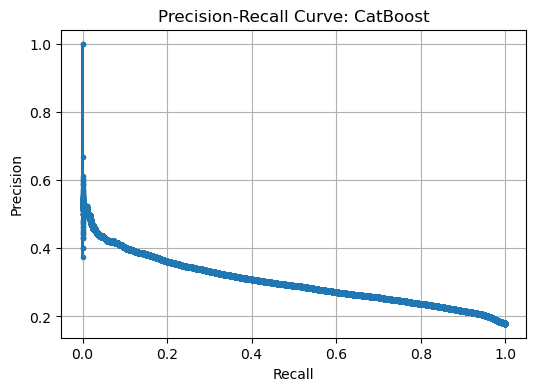

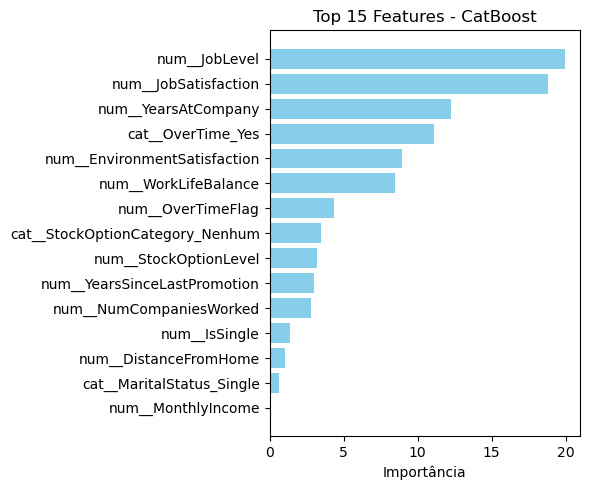


🎯 Fairness por: Department
Sales: Recall = 0.953, Precision = 0.199
Research & Development: Recall = 0.954, Precision = 0.205
Human Resources: Recall = 0.958, Precision = 0.205

🎯 Fairness por: MaritalStatus
Divorced: Recall = 0.953, Precision = 0.191
Married: Recall = 0.949, Precision = 0.195
Single: Recall = 0.962, Precision = 0.218

🎯 Fairness por: JobRole
Sales Representative: Recall = 0.952, Precision = 0.197
Manager: Recall = 0.958, Precision = 0.205
Research Director: Recall = 0.954, Precision = 0.200
Sales Executive: Recall = 0.950, Precision = 0.200
Research Scientist: Recall = 0.952, Precision = 0.206
Human Resources: Recall = 0.957, Precision = 0.202
Laboratory Technician: Recall = 0.950, Precision = 0.203

🎯 Fairness por: Gender
Male: Recall = 0.955, Precision = 0.204
Female: Recall = 0.952, Precision = 0.199

🎯 Fairness por: BusinessTravel
Non-Travel: Recall = 0.954, Precision = 0.204
Travel_Frequently: Recall = 0.956, Precision = 0.204
Travel_Rarely: Recall = 0.953, Prec

<Figure size 400x400 with 0 Axes>

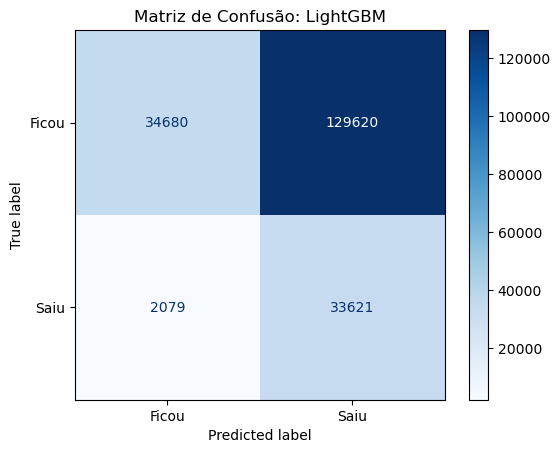


📊 Métricas específicas:
Precision: 0.2060
Recall: 0.9418
F1-Score: 0.3380
F2-Score: 0.5493
Balanced Accuracy: 0.5764
MCC: 0.1511
Precision-Recall AUC: 0.2997


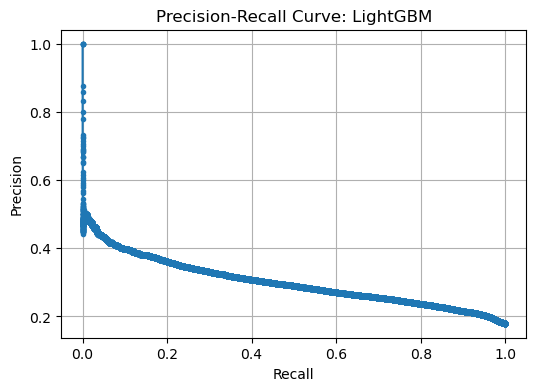

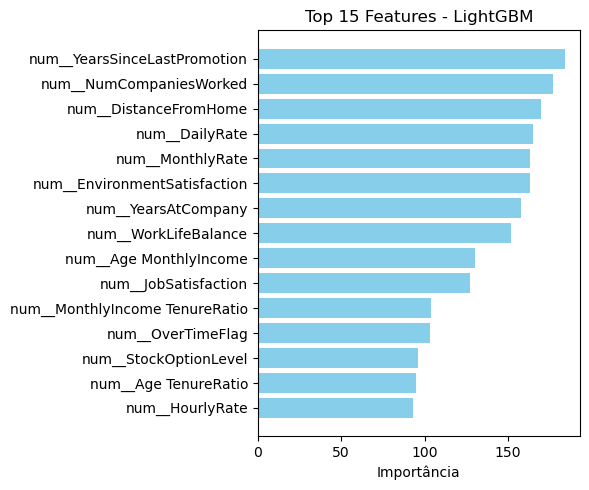


🎯 Fairness por: Department
Sales: Recall = 0.941, Precision = 0.203
Research & Development: Recall = 0.940, Precision = 0.208
Human Resources: Recall = 0.947, Precision = 0.208

🎯 Fairness por: MaritalStatus
Divorced: Recall = 0.939, Precision = 0.195
Married: Recall = 0.933, Precision = 0.200
Single: Recall = 0.957, Precision = 0.220

🎯 Fairness por: JobRole
Sales Representative: Recall = 0.939, Precision = 0.201
Manager: Recall = 0.947, Precision = 0.209
Research Director: Recall = 0.942, Precision = 0.204
Sales Executive: Recall = 0.939, Precision = 0.204
Research Scientist: Recall = 0.939, Precision = 0.210
Human Resources: Recall = 0.944, Precision = 0.206
Laboratory Technician: Recall = 0.935, Precision = 0.206

🎯 Fairness por: Gender
Male: Recall = 0.942, Precision = 0.208
Female: Recall = 0.941, Precision = 0.203

🎯 Fairness por: BusinessTravel
Non-Travel: Recall = 0.943, Precision = 0.208
Travel_Frequently: Recall = 0.941, Precision = 0.208
Travel_Rarely: Recall = 0.942, Prec

<Figure size 400x400 with 0 Axes>

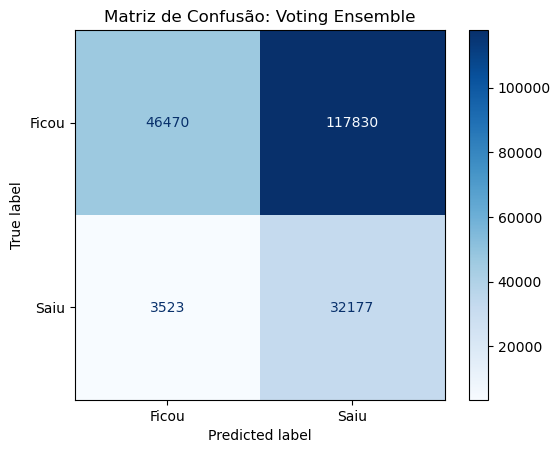


📊 Métricas específicas:
Precision: 0.2145
Recall: 0.9013
F1-Score: 0.3465
F2-Score: 0.5495
Balanced Accuracy: 0.5921
MCC: 0.1629
Precision-Recall AUC: 0.2944


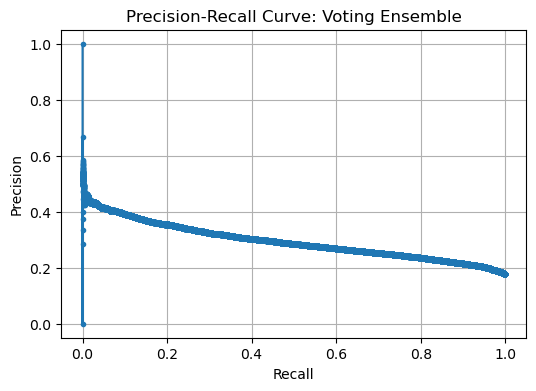


🎯 Fairness por: Department
Sales: Recall = 0.902, Precision = 0.212
Research & Development: Recall = 0.898, Precision = 0.217
Human Resources: Recall = 0.908, Precision = 0.218

🎯 Fairness por: MaritalStatus
Divorced: Recall = 0.891, Precision = 0.204
Married: Recall = 0.884, Precision = 0.210
Single: Recall = 0.931, Precision = 0.226

🎯 Fairness por: JobRole
Sales Representative: Recall = 0.901, Precision = 0.210
Manager: Recall = 0.907, Precision = 0.218
Research Director: Recall = 0.899, Precision = 0.211
Sales Executive: Recall = 0.898, Precision = 0.212
Research Scientist: Recall = 0.903, Precision = 0.220
Human Resources: Recall = 0.907, Precision = 0.215
Laboratory Technician: Recall = 0.885, Precision = 0.213

🎯 Fairness por: Gender
Male: Recall = 0.903, Precision = 0.217
Female: Recall = 0.899, Precision = 0.211

🎯 Fairness por: BusinessTravel
Non-Travel: Recall = 0.898, Precision = 0.216
Travel_Frequently: Recall = 0.905, Precision = 0.217
Travel_Rarely: Recall = 0.901, Prec

In [59]:
# ========================================================
# Treinamento e Avaliação de Múltiplos Modelos de ML
# ========================================================
# Este bloco implementa o pipeline completo para testar,
# ajustar e avaliar diferentes algoritmos de classificação
# com foco em predição de rotatividade de funcionários.

# 🔹 Modelos utilizados:
# - Random Forest
# - Logistic Regression
# - CatBoost
# - LightGBM
# - Voting Ensemble (combinação dos 4 modelos acima)

# 🔹 Etapas executadas:
# 1. Criação de dicionário com os modelos
# 2. Definição de grades de hiperparâmetros para otimização
# 3. Treinamento com validação cruzada (GridSearchCV para os modelos com hiperparâmetros)
# 4. Avaliação dos modelos com threshold ajustado (0.3)
# 5. Geração de métricas específicas: F1, F2, Balanced Accuracy, MCC, PR-AUC
# 6. Visualização:
#    - Matriz de confusão
#    - Curva Precision-Recall
#    - Gráfico de importância das variáveis (quando aplicável)
# 7. Avaliação de viés (fairness) por subgrupos (ex: gênero, cargo, departamento)
# 8. Armazenamento do modelo final (Voting Ensemble) em .pkl
# 9. Geração de tabela comparativa final com todas as métricas para análise

# 📝 Objetivo:
# Selecionar o melhor modelo para prever a saída de funcionários,
# garantindo alta sensibilidade (recall) e interpretabilidade,
# mesmo diante de um conjunto de dados desbalanceado.

# Modelos individuais + ensemble
modelos = {
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(verbose=0, auto_class_weights='Balanced'),
    'LightGBM': LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
    'Voting Ensemble': VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')),
            ('lr', LogisticRegression(max_iter=1000, class_weight='balanced')),
            ('lgbm', LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')),
            ('cat', CatBoostClassifier(verbose=0, auto_class_weights='Balanced'))
        ],
        voting='soft',
        n_jobs=-1
    )
}

# Modelos com hiperparâmetros
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_split': [2, 5],
    },
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs']
    },
    'CatBoost': {
        'classifier__depth': [4, 6],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__iterations': [100]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [-1, 10],
        'classifier__learning_rate': [0.01, 0.1]
    }
}
modelos_com_parametros = list(param_grids.keys())

def avaliar_fairness(df, grupo_coluna, y_true, y_pred):
    print(f"\n🎯 Fairness por: {grupo_coluna}")
    grupos = df[grupo_coluna].dropna().unique()
    for grupo in grupos:
        idx = df[grupo_coluna] == grupo
        if sum(idx) == 0:
            continue
        recall = recall_score(y_true[idx], y_pred[idx], zero_division=0)
        precision = precision_score(y_true[idx], y_pred[idx], zero_division=0)
        print(f"{grupo}: Recall = {recall:.3f}, Precision = {precision:.3f}")


# Resultados
resultados = []

for nome, modelo in modelos.items():
    print(f"\n🔍 Treinando modelo: {nome}")
    
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('classifier', modelo)
    ])

    if nome in modelos_com_parametros:
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grids[nome],
            cv=3,
            scoring='f1',
            n_jobs=4,
            verbose=1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        melhores_params = grid.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        melhores_params = "Não aplicável"

    # Avaliação com threshold
    y_scores = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_scores >= 0.3).astype(int)

    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Ficou", "Saiu"]))
    
    # 🔷 Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ficou", "Saiu"])

    plt.figure(figsize=(4, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão: {nome}')
    plt.grid(False)
    plt.show()
    

    # Métricas específicas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_scores)

    print("\n📊 Métricas específicas:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"F2-Score: {f2:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

    # Curva PR
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, marker='.')
    plt.title(f'Precision-Recall Curve: {nome}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()
    
    # 🔎 Importância das variáveis por modelo
    try:
        feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

        if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
            importances = best_model.named_steps['classifier'].feature_importances_

        elif nome == 'CatBoost':
            importances = best_model.named_steps['classifier'].get_feature_importance()

        elif hasattr(best_model.named_steps['classifier'], 'coef_'):
            importances = np.abs(best_model.named_steps['classifier'].coef_).flatten()

        else:
            importances = None

        if importances is not None:
            top_idx = importances.argsort()[-15:]
            top_features = feature_names[top_idx]
            top_importances = importances[top_idx]

            plt.figure(figsize=(6, 5))
            plt.barh(top_features, top_importances, color='skyblue')
            plt.title(f'Top 15 Features - {nome}')
            plt.xlabel('Importância')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"[!] Não foi possível calcular importâncias para o modelo {nome}: {e}")
        
     # 🔍 Análise de viés e fairness
    df_avaliacao = X_test.copy()
    df_avaliacao['y_true'] = y_test
    df_avaliacao['y_pred'] = y_pred

    for coluna in ['Department', 'MaritalStatus','JobRole','Gender','BusinessTravel','EducationField']:
        if coluna in df_avaliacao.columns:
            avaliar_fairness(df_avaliacao, coluna, df_avaliacao['y_true'], df_avaliacao['y_pred'])

    resultados.append({
        'Modelo': nome,
        'Melhores Params': melhores_params,
        'F1-score': f1,
        'F2-score': f2,
        'Balanced Accuracy': bal_acc,
        'MCC': mcc,
        'PR AUC': pr_auc
    })
    
    if nome == 'Voting Ensemble':
        joblib.dump(grid.best_estimator_, 'melhor_modelo_Voting_Ensemble.pkl') 

# Tabela final
df_resultados = pd.DataFrame(resultados).sort_values(by='F1-score', ascending=False).reset_index(drop=True)
print("\n📊 Comparativo final com métricas para desbalanceamento:")
print(df_resultados)